In [18]:
# Create a verison of the model without ousourcers (or on the job search) following L+S pg 953
# Solves both the decentralized and planner's problems

import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from numba import njit, jitclass, int64, float64
from interpolation import interp
from IPython.core.debugger import set_trace
from scipy.optimize import minimize

class LSModel:
    """
    B is discount rate beta
    r is interest rate defined by beta
    b is home production
    delta is job loss rate 
    eta is workers bargaining power
    phi is effectiveness of matching function
    alpha is elasticity of matching function
    y_min, y_max, y_grid_size determine firm productivity grid
    rm is to Reimann Sum approximate firm integrals
    gamma is steepness of marginal cost, 
    c_grid is level of entry cost
    """
    def __init__(self, B, b, delta, eta, phi, alpha, y_min, y_max, y_grid_size, gamma, c_grid):
        
        self.B, self.b, self.delta, self.eta, self.gamma, self.c_grid = B, b, delta, eta, gamma, c_grid
        self.r = 1 / B - 1
        
        self.y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint = False)
        self.y_grid_size, self.y_min, self.y_max = y_grid_size, y_min, y_max    
        self.rm = (y_max - y_min) / y_grid_size
        
        self.phi, self.alpha = phi, alpha
        
# Set up neccesary functions
def ls_operator_factory(ls):
    
    r, b, delta, eta, gamma, c_grid = ls.r, ls.b, ls.delta, ls.eta, ls.gamma, ls.c_grid
    phi, alpha = ls.phi, ls.alpha
    
    y_grid, y_grid_size, rm, y_max = ls.y_grid, ls.y_grid_size, ls.rm, ls.y_max    
    
    @njit()
    def q(theta):
        return min(phi * theta**(-alpha), 1)
    
    @njit()
    def ell(theta):
        return min(phi * theta**(1 - alpha), 1)
    
    # Want cost of vacancy, marginal cost of vacancy, and inverse marginal cost of vacancy
    @njit()
    def C(v_grid):
        return c_grid * v_grid**gamma
    
    @njit()
    def c(v_grid):
        return c_grid * gamma * v_grid**(gamma - 1)

    @njit()
    def c_inv(cost_grid):
        return (np.maximum(cost_grid, 0) / (gamma * c_grid))**(1 / (gamma - 1))
    
    # Given v_grid, and n_grid find the distribution of workers
    # Including market tightness theta and distribution of vacancies f_grid
    @njit()
    def worker_dist(v_grid, n_grid):
        
        # Define aggregate populations (make sure all exist)
        n = max(np.sum(n_grid * rm), 1e-9)
        u = max(1 - n, 1e-9)
        v = max(np.sum(v_grid * rm), 1e-9)
        
        # Calculate theta 
        theta = v / u
        
        # f is pdf of vacancies 
        f_grid = v_grid / v
        
        return theta, f_grid
    
    # Solve decentralized problem
    # Given v_grid, and n_grid find
    # Market tightness theta and Wages w
    @njit()
    def make_grids(v_grid, n_grid):    
        
        # Get distribution of workers
        theta, f_grid = worker_dist(v_grid, n_grid)
        
        # What is the value of search for unemployed?
        f_tot = np.sum(c(v_grid) * f_grid * rm)
        Gamma_U = ell(theta) / q(theta) * eta / (1 - eta) * f_tot
        
        # Find wage
        w_grid = eta * y_grid + (1 - eta) * (b + Gamma_U)
        
        return theta, w_grid
    
    # Given v_grid and n_grid find new values
    @njit()
    def iterate(v_grid, n_grid):
        
        theta, w_grid = make_grids(v_grid, n_grid)
        
        # Value of firm
        J_hire = q(theta) * (y_grid - w_grid) / (r + delta)
        
        # Update vacancies
        v_grid_new = c_inv(J_hire)
        
        # Update positions
        n_grid_new = (1 - delta) * n_grid + q(theta) * v_grid_new
                       
        return v_grid_new, n_grid_new
    
    # Solve Planner's problem
    # Given v_grid and n_grid find
    # Market tightness theta
    # Planner's value of worker search Gamma_P
    # The lagrange multiplier lamda_grid
    @njit()
    def p_make_grids(v_grid, n_grid):    
        
        # Get distribution of workers
        theta, f_grid = worker_dist(v_grid, n_grid)
        
        # What is the value of search for unemployed?
        f_tot = np.sum(c(v_grid) * f_grid * rm)
        Gamma_P = ell(theta) / q(theta) * alpha / (1 - alpha) * f_tot
        
        # Find lagrange multiplier lamda_grid
        lambda_grid = (y_grid - b - Gamma_P) / (r + delta)
        
        return theta, Gamma_P, lambda_grid
    
    # Given v_grid and n_grid find new values
    @njit()
    def p_iterate(v_grid, n_grid):
        
        # Get theta, Gamma_P, and lambda_grid
        theta, Gamma_P, lambda_grid = p_make_grids(v_grid, n_grid)
        
        # Value of firms
        J_hire = lambda_grid * q(theta) - Gamma_P / theta
        
        # Update vacancies
        v_grid_new = c_inv(J_hire)
        
        # Update positions
        n_grid_new = (1 - delta) * n_grid + q(theta) * v_grid_new
                       
        return v_grid_new, n_grid_new
    
    return iterate, make_grids, p_iterate, p_make_grids, C, c, c_inv, q, ell 

# Solve model, both decentralized and Planner 
def ls_solve_model(ls, guess, tol, max_iter, slow, planner=False, verbose=False, print_skip=1e4):
    
    if planner == False:
        iterate, _, _, _, _, _, _, _, _ = ls_operator_factory(ls)
    else:
        _, _, iterate, _, _, _, _, _, _ = ls_operator_factory(ls)
    
    v_grid, n_grid = guess

    # Set up initial loop parameters
    i = 0
    err = tol + 1    

    # Update v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, and y_hat
    while i < max_iter and err > tol:
        v_grid_new, n_grid_new = iterate(v_grid, n_grid)
        err_v = np.max(np.abs(v_grid_new - v_grid))
        err_n = np.max(np.abs(n_grid_new - n_grid))
        err = max(err_v, err_n)

        v_grid = slow * v_grid_new + (1 - slow) * v_grid
        n_grid = slow * n_grid_new + (1 - slow) * n_grid
        
        if verbose and i % print_skip == 0:
            print(f"Error at iter {i} is {err:.4f}") 
        
        i += 1
    
    if i < max_iter:
        print(f'Converged in {i} iterations')
    if i == max_iter:
        print(f'Failed to Converge.')

    return v_grid_new, n_grid_new

# Graph decentralized results
def ls_graph_results(ls, v_grid, n_grid,
                  save=False, height=7, 
                  folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures\Python Simulations\Test',
                  file=r'\LS'):
    
    # Make sure dimensions are 1:1.62
    width = height * 1.62
    
    # Get data needed from ls
    iterate, make_grids, p_iterate, p_make_grids, C, c, c_inv, q, ell = ls_operator_factory(ls)
    
    theta, w_grid = make_grids(v_grid, n_grid)
    
    r, delta = ls.r, ls.delta
    c_grid = ls.c_grid
    rm = ls.rm
    y_grid, y_grid_size = ls.y_grid, ls.y_grid_size
        
    # Graph wages by productivity    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, w_grid, lw=2, alpha=0.75, c='b')
    ax.plot(y_grid, y_grid, lw=.5, alpha=0.5, c='k', ls=":")
    
    if save:
        fig.savefig(folder + file + 'LS Wages v Productivity.pdf')
    else:
        plt.show()   

    # Graph vacacies by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid, rm * v_grid, lw=2, alpha=0.75, label="Firms")
    ax.set(xlabel="Wage $w$", ylabel="Vacancies $v$")
    
    if save:
        fig.savefig(folder + file + 'LS Vacancies v Wages.pdf')
    else:
        plt.show()         
    
    # Graph filled posititions by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid, rm * n_grid, lw=2, alpha=0.75, label="Firms")
    ax.set(xlabel="Wage $w$", ylabel="Positions $n$")
    
    if save:
        fig.savefig(folder + file + 'LS Positions v Wages.pdf')
    else:
        plt.show() 
        
    # Graph firm vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, rm * v_grid, lw=2, alpha=0.75)
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies")
    
    if save:
        fig.savefig(folder + file + 'LS Firm Vacancies.pdf')
    else:
        plt.show()
        
    # Graph firm postions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, rm * n_grid, lw=2, alpha=0.75)
    ax.set(xlabel="Productivity $y$", ylabel="Positions")
    
    if save:
        fig.savefig(folder + file + 'LS Firm Positions.pdf')
    else:
        plt.show()
        
    # Graph the marginal value of a worker to each firm and marginal cost of aquiring one.
    # Do the same for outsourcers hiring
    J_hire = q(theta) * (y_grid - w_grid) / (r + delta)
    mc = c(v_grid)   
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, J_hire, lw=2, alpha=0.75, label="Firm Marginal Value")
    ax.plot(y_grid, mc, lw=2, alpha=0.75, label="Firm Marginal Cost")
    ax.set(xlabel="Productivity", ylabel="Value")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'LS M Value and Cost.pdf')
    else:
        plt.show()
        
    # Plot the differences from the above curves
    J_hire_diff = J_hire - mc
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[v_grid > 0],
            J_hire_diff[v_grid > 0], lw=2, alpha=0.75)
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    
    if save:
        fig.savefig(folder + file + 'LS M Value Minus Cost.pdf')
    else:
        plt.show()
        
    # Plot the actual vs theoretical spread of vacancies
    spread_theory = (c(v_grid)[-1] - c(v_grid)) * (r + delta) / ((1 - eta) * q(theta))
    
    spread_prod = y_grid[-1] - y_grid
    spread_prod[v_grid == 0] = spread_theory[v_grid == 0]
    
    dif = spread_prod - spread_theory
    
    fig, ax = plt.subplots()
    ax.plot(y_grid, spread_prod, lw=2, alpha=0.75, label='Code')
    ax.plot(y_grid, spread_theory, lw=2, alpha=0.75, label='Theoretical')
    ax.set(xlabel='$y$', ylabel='Spread', title='Spread of Vacancies')
    ax.legend(loc='best')
    
    if save:
        fig.savefig(folder + file + 'LS Spread.pdf')
    else:
        plt.show()   
        
    fig, ax = plt.subplots()
    ax.plot(y_grid, dif, lw=2, alpha=0.75)
    ax.set(xlabel='$y$', ylabel='Spread', title='Difference in Spread of Vacancies')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
    
    if save:
        fig.savefig(folder + file + 'LS Spread Dif')
    else:
        plt.show() 
        
# Create a function to print some facts that are useful for decentralized
def ls_list_facts(ls, v_grid, n_grid):
    
    iterate, make_grids, p_iterate, p_make_grids, C, c, c_inv, q, ell = ls_operator_factory(ls)
    
    theta, w_grid = make_grids(v_grid, n_grid)
    
    r, delta = ls.r, ls.delta
    gamma, c_grid, eta = ls.gamma, ls.c_grid, ls.eta
    rm = ls.rm
    y_grid = ls.y_grid
    
    u = 1 - np.sum(n_grid * rm)
    u_lom = delta / (delta + ell(theta))
    v = np.sum(v_grid * rm)
    
    print(f"Unemployment is {u * 100:.2f}. According to LoM, should be {u_lom * 100:.2f}")
    print(f"Workers match with probability {ell(theta) * 100:.2f}.",
          f"Firms/Outsourcers match with probability {q(theta) * 100:.2f}")
    print(f"Total vacancies searching for workers are {v:.4f}. Theta is {theta:.4f}")
                       
    # Do firm/outsourcer vacancies and positions line up in steady state?
    n_ss = v_grid * q(theta) / delta
    err = max(np.abs(n_ss - n_grid))
    err_at = np.argmax(np.abs(n_ss - n_grid))
    
    print(
        "Checking if vacancies + LoM imply right positions:\n",
         f"Firms largest error = {err:.6f} at position {err_at} \n"
    )  
    
    # Check if entry is consitent with theory
    firm_sum = np.sum(c(v_grid) * v_grid * rm)
    
    entry_code = np.sum(v_grid * (y_grid - b) * rm)
    
    entry_theory = (r + delta + eta * theta * q(theta)) / ((1 - eta) * q(theta)) * firm_sum
    
    print(f'Hiring entry from code {entry_code:.4f}; theory {entry_theory:.4f}')
    
# Graph Planner results
def ls_p_graph_results(ls, v_grid, n_grid,
                  save=False, height=7, 
                  folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures\Python Simulations\Test',
                  file=r'\Outsourcers Basic'):
    
    # Make sure dimensions are 1:1.62
    width = height * 1.62
    
    # Get data needed from ls
    iterate, make_grids, p_iterate, p_make_grids, C, c, c_inv, q, ell = ls_operator_factory(ls)
    
    theta, Gamma_P, lambda_grid = p_make_grids(v_grid, n_grid)
    
    r, delta = ls.r, ls.delta
    c_grid = ls.c_grid
    rm = ls.rm
    y_grid, y_grid_size = ls.y_grid, ls.y_grid_size
         
    # Graph firm vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, rm * v_grid, lw=2, alpha=0.75)
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies")
    
    if save:
        fig.savefig(folder + file + 'LS Planner Firm Vacancies.pdf')
    else:
        plt.show()
        
    # Graph firm postions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, rm * n_grid, lw=2, alpha=0.75)
    ax.set(xlabel="Productivity $y$", ylabel="Positions")
    
    if save:
        fig.savefig(folder + file + 'LS Planner Firm Positions.pdf')
    else:
        plt.show()
        
    # Graph the marginal value of a worker to each firm and marginal cost of aquiring one.
    # Do the same for outsourcers hiring
    J_hire = lambda_grid * q(theta) - Gamma_P / theta    
    mc = c(v_grid)   
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, J_hire, lw=2, alpha=0.75, label="Firm Marginal Value")
    ax.plot(y_grid, mc, lw=2, alpha=0.75, label="Firm Marginal Cost")
    ax.set(xlabel="Productivity", ylabel="Value")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'LS Planner M Value and Cost.pdf')
    else:
        plt.show()
        
    # Plot the differences from the above curves
    J_hire_diff = J_hire - mc
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[v_grid > 0],
            J_hire_diff[v_grid > 0], lw=2, alpha=0.75)
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    
    if save:
        fig.savefig(folder + file + 'LS Planner M Value Minus Cost.pdf')
    else:
        plt.show()
        
    # Plot the actual vs theoretical spread of vacancies
    spread_theory = (c(v_grid)[-1] - c(v_grid)) * (r + delta) / q(theta)
    
    spread_prod = y_grid[-1] - y_grid
    spread_prod[v_grid == 0] = spread_theory[v_grid == 0]
    
    dif = spread_prod - spread_theory
    
    fig, ax = plt.subplots()
    ax.plot(y_grid, spread_prod, lw=2, alpha=0.75, label='Code')
    ax.plot(y_grid, spread_theory, lw=2, alpha=0.75, label='Theoretical')
    ax.set(xlabel='$y$', ylabel='Spread', title='Spread of Vacancies')
    ax.legend(loc='best')
    
    if save:
        fig.savefig(folder + file + 'LS Planner Spread.pdf')
    else:
        plt.show()   
        
    fig, ax = plt.subplots()
    ax.plot(y_grid, dif, lw=2, alpha=0.7)
    ax.set(xlabel='$y$', ylabel='Spread', title='Difference in Spread of Vacancies')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
    
    if save:
        fig.savefig(folder + file + 'LS Planner Spread Dif')
    else:
        plt.show() 
        
# Create a function to print some facts that are useful for Planner's
def ls_p_list_facts(ls, v_grid, n_grid):
    
    # Get data needed from ls
    iterate, make_grids, p_iterate, p_make_grids, C, c, c_inv, q, ell = ls_operator_factory(ls)
    
    theta, Gamma_P, lambda_grid = p_make_grids(v_grid, n_grid)
    
    r, delta = ls.r, ls.delta
    gamma, c_grid, eta = ls.gamma, ls.c_grid, ls.eta
    rm = ls.rm
    y_grid = ls.y_grid
    
    alpha = 1 - ls.alpha
    
    u = 1 - np.sum(n_grid * rm)
    u_lom = delta / (delta + ell(theta))
    v = np.sum(v_grid * rm)
    
    print(f"Unemployment is {u * 100:.2f}. According to LoM, should be {u_lom * 100:.2f}")
    print(f"Workers match with probability {ell(theta) * 100:.2f}.",
          f"Firms/Outsourcers match with probability {q(theta) * 100:.2f}")
    print(f"Total vacancies searching for workers are {v:.4f}. Theta is {theta:.4f}")
                       
    # Do firm/outsourcer vacancies and positions line up in steady state?
    n_ss = v_grid * q(theta) / delta
    err = max(np.abs(n_ss - n_grid))
    err_at = np.argmax(np.abs(n_ss - n_grid))
    
    print(
        "Checking if vacancies + LoM imply right positions:\n",
         f"Firms largest error = {err:.6f} at position {err_at} \n"
    )  
    
    # Check if entry is consitent with theory
    firm_sum = np.sum(c(v_grid) * v_grid * rm)
    
    entry_code = np.sum(v_grid * (y_grid - b) * rm)
    
    entry_theory = (r + delta + alpha * theta * q(theta)) / ((1 - alpha) * q(theta)) * firm_sum
    
    print(f'Hiring entry from code {entry_code:.4f}; theory {entry_theory:.4f}')

Error at iter 0 is 4.0086
Error at iter 10000 is 0.0001
Error at iter 20000 is 0.0000
Error at iter 30000 is 0.0000
Converged in 32454 iterations
TOC: Elapsed: 0:00:9.01
Unemployment is 10.10. According to LoM, should be 10.10
Workers match with probability 3.48. Firms/Outsourcers match with probability 15.39
Total vacancies searching for workers are 0.0229. Theta is 0.2263
Checking if vacancies + LoM imply right positions:
 Firms largest error = 0.000003 at position 450 

Hiring entry from code 0.0676; theory 0.0676


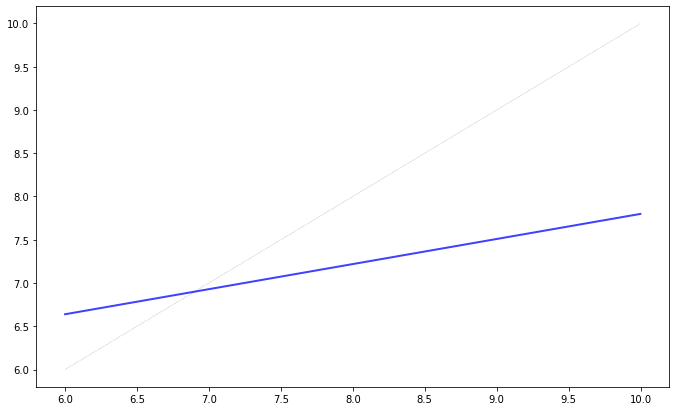

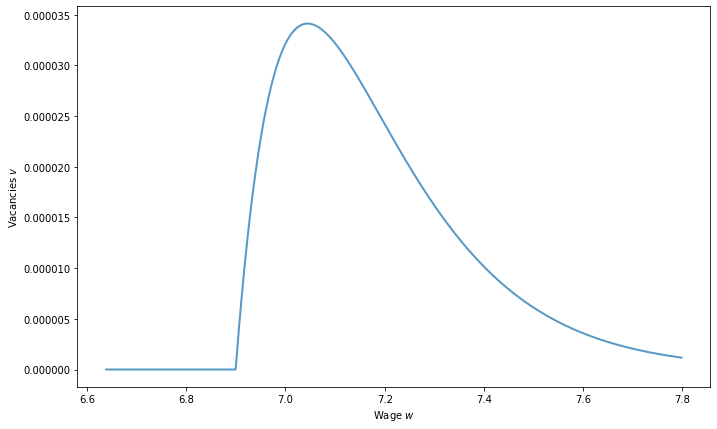

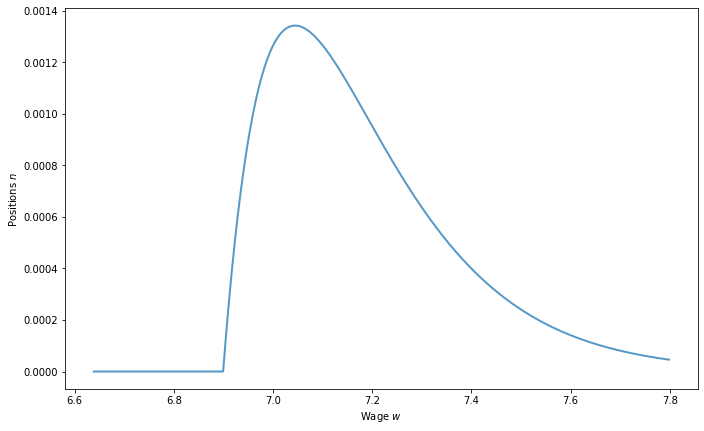

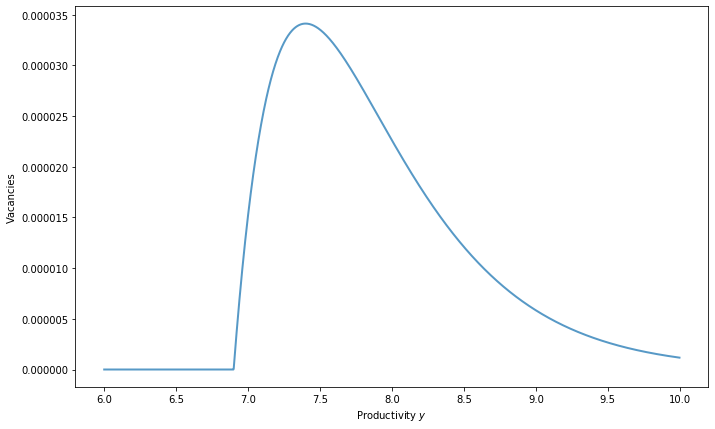

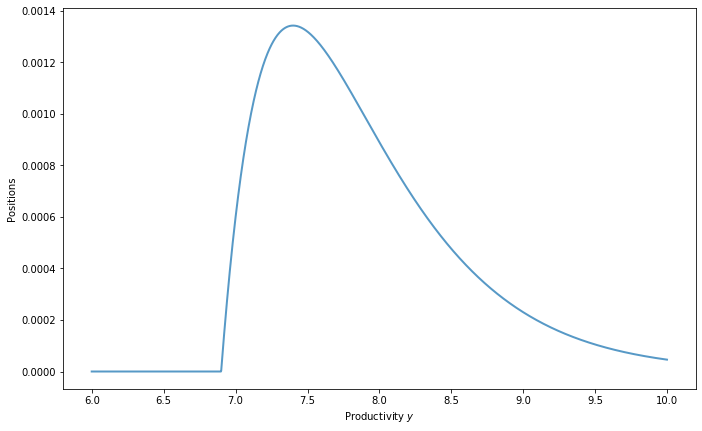

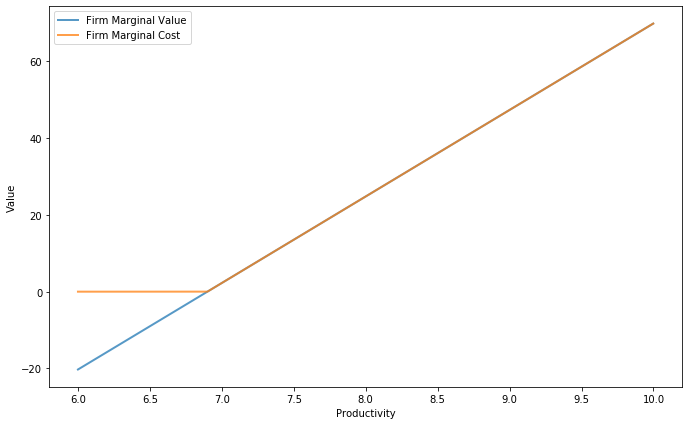

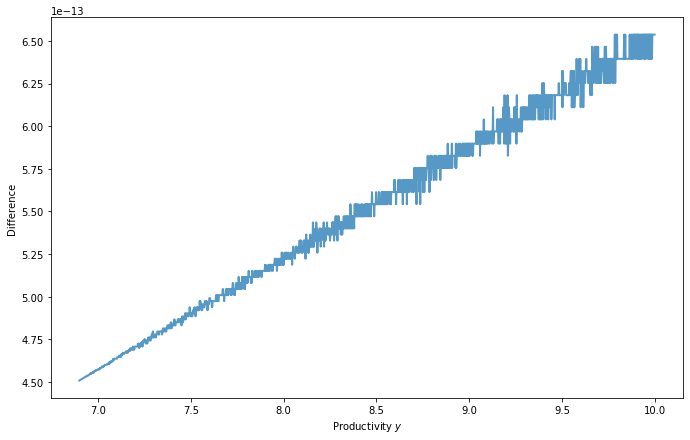

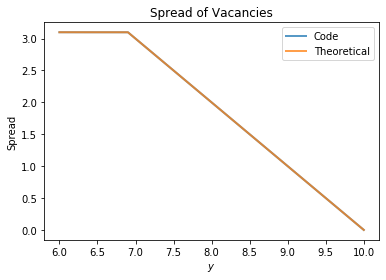

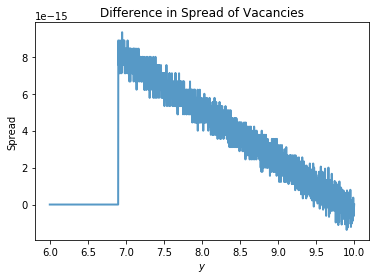

In [19]:
# Decentralized
r = 0.000939
B = 1 / (1 + r)
delta = 0.003911083
alpha = .29
phi = .1
eta = alpha
# eta = .5
y_min = 6
y_max = 10
b = 7 * .7 
y_grid_size = 2000
gamma = 2
y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint = False)
c_grid = np.exp(-9 + 2 * y_grid)

tol = 1e-8
max_iter = 1e5
# max_iter = 50
slow = 1e-1
print_skip = 1e4
verbose = True

ls = LSModel(B, b, delta, eta, phi, alpha, y_min, y_max, y_grid_size, gamma, c_grid)

# Record initial guesses
v_grid = np.ones(y_grid_size) / y_grid_size**2
n_grid = np.ones(y_grid_size) / y_grid_size**2

guess = v_grid, n_grid

qe.tic()
v_grid, n_grid = ls_solve_model(
    ls, guess, tol, max_iter, slow, planner=False, verbose=verbose, print_skip=print_skip)
qe.toc()    
    
ls_list_facts(ls, v_grid, n_grid)

ls_graph_results(ls, v_grid, n_grid)

Error at iter 0 is 0.0045
Error at iter 10000 is 0.0000
Error at iter 20000 is 0.0000
Error at iter 30000 is 0.0000
Converged in 31260 iterations
TOC: Elapsed: 0:00:5.91
Unemployment is 21.05. According to LoM, should be 21.05
Workers match with probability 1.47. Firms/Outsourcers match with probability 68.18
Total vacancies searching for workers are 0.0045. Theta is 0.0215
Checking if vacancies + LoM imply right positions:
 Firms largest error = 0.000003 at position 1045 

Hiring entry from code 0.0194; theory 0.0194


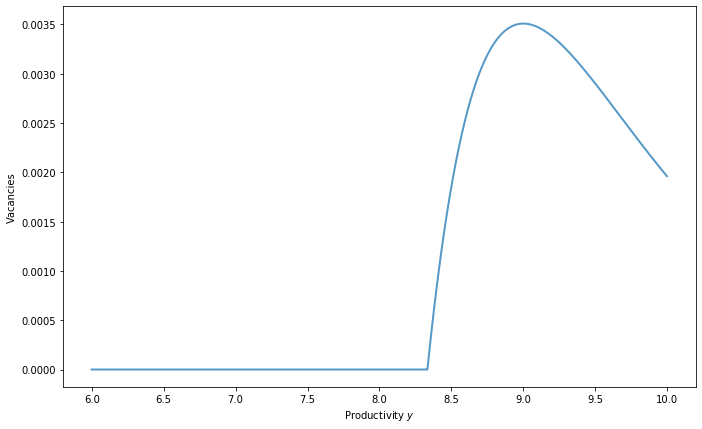

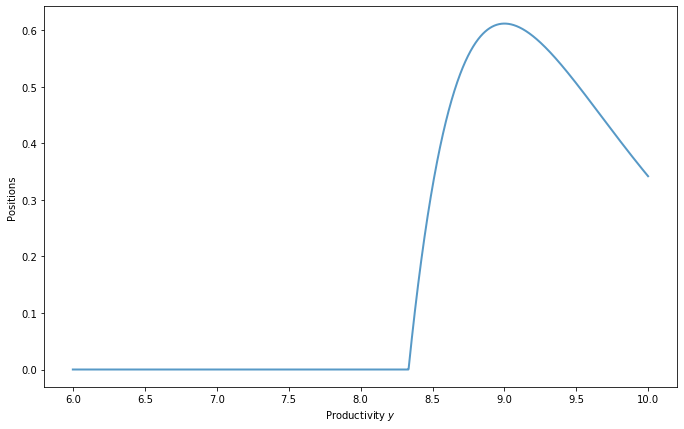

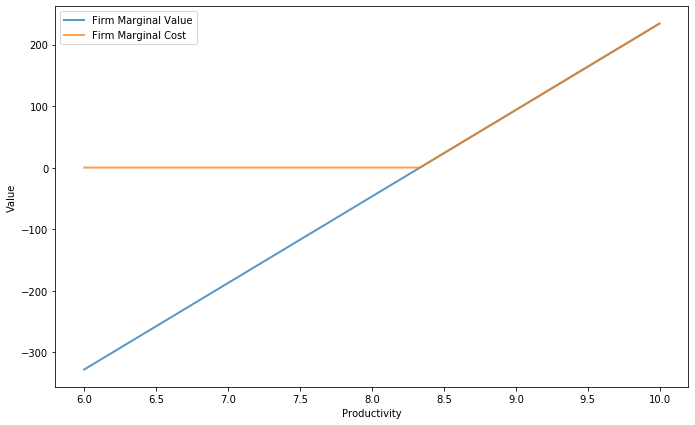

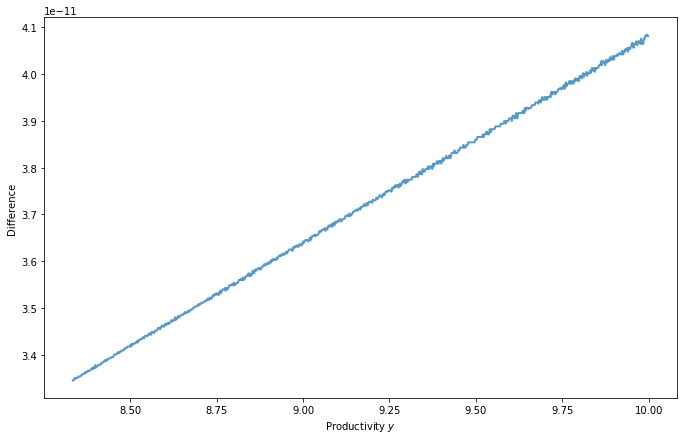

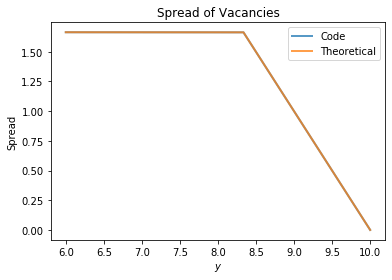

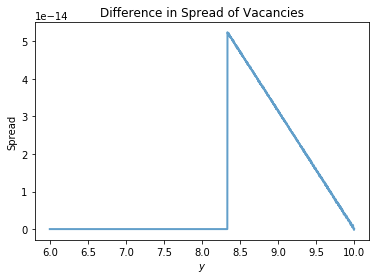

In [17]:
# Planner's (run above cell first)
tol = 1e-8
max_iter = 1e5
# max_iter = 50
slow = 1e-1
print_skip = 1e4
verbose = True

# Take guess from previous
guess = v_grid, n_grid

qe.tic()
v_grid_p, n_grid_p = ls_solve_model(
    ls, guess, tol, max_iter, slow, planner=True, verbose=verbose, print_skip=print_skip)
qe.toc()    
    
ls_p_list_facts(ls, v_grid_p, n_grid_p)

ls_p_graph_results(ls, v_grid_p, n_grid_p)

In [40]:
# Old version of code
# Create a baseline version of the model following L+S pg 953

import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from numba import njit, prange, vectorize
from scipy import optimize
from IPython.core.debugger import set_trace

# Want to vectorize cost of vacancy, marginal cost of vacancy, and inverse marginal cost of vacancy
@vectorize
def C(v, gamma, k_grid):
    return k_grid * v**gamma
   
@vectorize
def c(v, gamma, k_grid):
    if v > 0:
        return k_grid * gamma * v**(gamma - 1)
    else:
        return 0
     
@vectorize
def c_inv(c, gamma, k_grid):
    if c > 0:
        return (c / gamma / k_grid)**(1 / (gamma - 1))
    else:
        return 0
    
# Set up the baseline environment, starting with a discrete model
# For now, have entry costs be exponential, matching probability be q=phi * theta**(1 / 2) 
class BaselineDiscrete:
    """
    B is discount rate beta
    r is interest rate defined by beta
    b is home production
    delta is job loss rate
    eta is worker bargaining power    
    phi is effectiveness of matching function
    q is firm's matching function, worker's is p=theta*q(theta)
    y_min, y_max, y_grid_size determine productivity grid
    gamma is steepness of marginal cost, k_grid is distribution of firm entry costs
    q is matching function of firms
    p is matching function of workers    
    """
    def __init__(self, B, b, delta, eta, phi, y_min, y_max, y_grid_size, gamma, k_grid):
        
        self.B, self.b, self.delta, self.eta, self.gamma, self.k_grid = B, b, delta, eta, gamma, k_grid
        self.r = 1 / B - 1
        
        self.y_grid = np.linspace(y_min, y_max, y_grid_size)
        self.y_grid_size = y_grid_size        
        
        self.q = njit(lambda x: min(phi * x**(-1 / 2), 1))
        self.p = njit(lambda x: min(phi * x**(1 / 2), 1))
        self.q_p = njit(lambda x: -phi / 2 * x**(-3 / 2))
        
        
# Set up functions of problem
def operator_factory(bl):
    "Use a baseline case bl and create a function to find next vacancy and unemployment iterations"
    
    B, r, b, delta, eta, gamma, k_grid = bl.B, bl.r, bl.b, bl.delta, bl.eta, bl.gamma, bl.k_grid
    y_grid, y_grid_size = bl.y_grid, bl.y_grid_size
    q, p = bl.q, bl.p
    
    # Find wages for each postion and market tightness theta
    @njit()
    def wages(v_grid, u):
        w_grid = b + eta * (y_grid - b + np.sum(c(v_grid, gamma, k_grid) * v_grid) / u)
        theta = np.sum(v_grid) / u
        return w_grid, theta
    
    # Find next v_grid and u
    @njit()
    def iterate(v_grid, u):  

        w_grid, theta = wages(v_grid, u) 

        # Use w_grid to find out how many of firm i wants to enter (cannot be below 0)
        v_grid_new = c_inv(q(theta) * (y_grid - w_grid) / (r + delta), gamma, k_grid)
        
#         # Update u_new using steady state rule
#         u_new = delta / (delta + p(theta))

        # Try updating u_new using unemployed workers
        n_grid_new = q(theta) * v_grid_new / delta
        u_new = max(1 - np.sum(n_grid_new), 1e-5)
        
        return v_grid_new, u_new 
    
    return iterate, wages

def solve_model(bl, tol=1e-4, max_iter=1000, verbose=True, print_skip=25, slow=1/100):
    
    iterate, wages = operator_factory(bl)
    
    # Set up initial guesses and loop parameters
    v_grid = np.ones(bl.y_grid_size) / bl.y_grid_size
    u = 0.05
    i = 0
    err = tol + 1    
    
    # Update v_grid and u each period
    while i < max_iter and err > tol:
        v_grid_new, u_new = iterate(v_grid, u)
        err_v = np.max(np.abs(v_grid_new - v_grid))
        err_u = np.abs(u_new - u)
        err = max(err_v, err_u)
        i += 1
        
        if verbose and i % print_skip == 0:
            print(f'Error at iter {i} is {err}')
        
        v_grid = slow * v_grid_new + (1 - slow) * v_grid 
        u = slow * u_new + (1 - slow) * u
        
    if i == max_iter:
        print("Failed to Converge")
        
    if verbose and i < max_iter:
        print(f'Converged in {i} iterations')
    
    return v_grid_new, u_new

# Can check code against theoretical results by looking at spread and number of entrants
# For spread of entrants, compare each firms entry to highest. Graph results
# Keep in mind that spread_theory doesn't know that vacancies cannot be negative
def spread(bl, v_grid, u,
           save=False, folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures', file=r'\Baseline\spread'):
    
    gamma, k_grid, eta, r, delta = bl.gamma, bl.k_grid, bl.eta, bl.r, bl.delta
    q, y_grid = bl.q, bl.y_grid
    
    theta = np.sum(v_grid) / u
    
    # Find highest positive entry
    i_m = np.argmax(y_grid[v_grid > 0])    
    
    spread_prod = (c(v_grid[i_m], gamma, k_grid[i_m]) - c(v_grid, gamma, k_grid)) * (r + delta) / ((1 - eta) * q(theta))
    spread_theory = (y_grid[i_m] - y_grid) 
    spread_theory[v_grid == 0] = spread_prod[v_grid == 0]
    dif = spread_theory - spread_prod
    
    fig, ax = plt.subplots()
    ax.plot(y_grid, spread_prod, lw=2, alpha=0.7, label='Production')
    ax.plot(y_grid, spread_theory, lw=2, alpha=0.7, label='Theoretical')
    ax.set(xlabel='$y$', ylabel='Spread', title='Spread of Vacancies')
    ax.legend(loc='best')
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '.pdf')
    else:
        plt.show()   
        
    fig, ax = plt.subplots()
    ax.plot(y_grid, dif, lw=2, alpha=0.7)
    ax.set(xlabel='$y$', ylabel='Spread', title='Difference in Spread of Vacancies')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '_dif.pdf')
    else:
        plt.show()  

# For number of vacancies, just have two numbers to compare
def entry(bl, v_grid, u):
    
    b, gamma, k_grid, eta, r, delta = bl.b, bl.gamma, bl.k_grid, bl.eta, bl.r, bl.delta
    q, p, y_grid = bl.q, bl.p, bl.y_grid
    
    theta = np.sum(v_grid) / u
    
    entry_theory = np.sum(v_grid * (y_grid - b))
    entry_code = (r + delta + eta * theta * q(theta)) * np.sum(v_grid * c(v_grid, gamma, k_grid)) / ((1 - eta) * q(theta))
    
    print(f'Entry from code gives {entry_code:.4f}; Entry from theory gives {entry_theory:.4f}')
    
    # While doing this, also check if u is consistent with LOM
    u_t = delta / (delta + p(theta))    
    print(f'unemployment in model is {u:.4f}; according to LOM, should be {u_t:.4f}')
    # Probably related to whether p and q are < 1. Check these
    print(f'Employees match w/prob {p(theta):.2f}, employers match w/prob {q(theta):.2f}')
    
# Create a pdf of wage distribution
def bl_wage_dist(v_grid, w_grid,
           save=False, folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures', file=r'\Baseline\wage_dist'):
    
    w_plot = w_grid[v_grid > 0]
    v_pdf = v_grid[v_grid > 0] / sum(v_grid)
    
    fig, ax = plt.subplots()
    ax.plot(w_plot, v_pdf, alpha=0.7, color='b')
    ax.fill_between(w_plot, 0, v_pdf, alpha=0.1, color='b')
    ax.set(xlabel='Wages', ylabel='Density')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
    
    if save:
        fig.savefig(folder + file + '.pdf')
    else:
        plt.show()     

Error at iter 1000 is 0.3496603138462625
Error at iter 2000 is 0.1285684976252499
Error at iter 3000 is 0.7327075253977559
Error at iter 4000 is 0.269413204784016
Error at iter 5000 is 0.056130476708050686
Error at iter 6000 is 0.01612129883421344
Error at iter 7000 is 0.004807749236635003
Error at iter 8000 is 0.0013505470242279882
Error at iter 9000 is 0.00030817952702467954
Error at iter 10000 is 2.2342446557604978e-05
Error at iter 11000 is 3.718194585351775e-05
Error at iter 12000 is 3.6850453706202546e-05
Error at iter 13000 is 2.5549759398613148e-05
Error at iter 14000 is 1.5648256261727167e-05
Error at iter 15000 is 9.044701363064567e-06
Error at iter 16000 is 5.0612808697447775e-06
Error at iter 17000 is 2.7768515753756606e-06
Error at iter 18000 is 1.5020427333728437e-06
Error at iter 19000 is 8.055071274576386e-07
Error at iter 20000 is 4.3005083442959613e-07
Error at iter 21000 is 2.289063667643143e-07
Error at iter 22000 is 1.2159058564165104e-07
Error at iter 23000 is 6.4

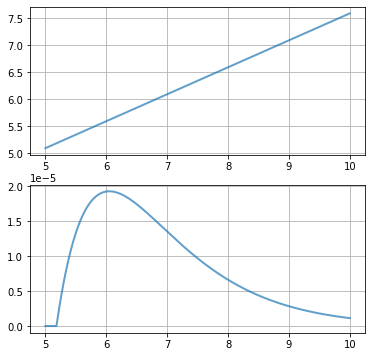

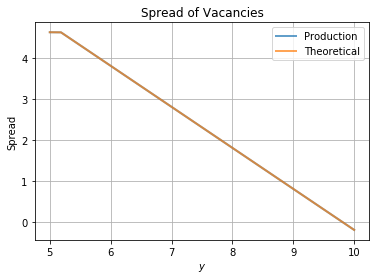

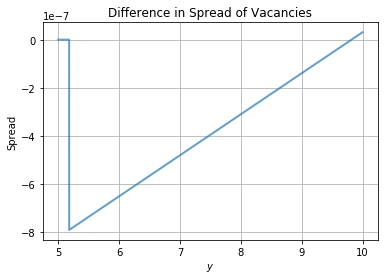

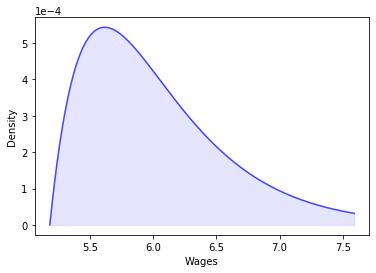

In [68]:
B = 0.95
r = 1 / B - 1
delta = 0.03
eta = 0.5
# phi = 1
u_set = 0.05
phi = 5e-1 
# y_min = 1
y_min = 5
y_max = 10
b = y_min * .4 
# print(phi, phi**2, k)
y_grid_size = 4000
# y_grid_size = 100
gamma = 2
# gamma = 1.5
k_grid = np.logspace(4.5, 7, y_grid_size)
# k_grid = np.logspace(1, 2, y_grid_size)**3

bl = BaselineDiscrete(B, b, delta, eta, phi, y_min, y_max, y_grid_size, gamma, k_grid)

iterate, wages = operator_factory(bl)
v_grid, u = solve_model(bl, tol=1e-8, print_skip=1e3, max_iter=1e5, slow=1e-3)

w_grid, theta = wages(v_grid, u)

print(u, theta, bl.q(theta), bl.p(theta))
# print(np.sum(c(v_grid, gamma) * f_grid))
# print(np.sum(v_grid))


entry(bl, v_grid, u)
# print(v_grid)
# print(w_grid)

# Plot v_grid and w_grid
fig, axes = plt.subplots(2, figsize=(6,6))
axes[0].plot(bl.y_grid, w_grid, lw=2, alpha=0.7)
axes[0].grid()
axes[1].plot(bl.y_grid, v_grid, lw=2, alpha=0.7)
axes[1].ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
axes[1].grid()

plt.show()

spread(bl, v_grid, u)

bl_wage_dist(v_grid, w_grid)

In [11]:
k_grid

array([  31622.77660168,   31659.21374885,   31695.6928805 , ...,
       3155002.80675434, 3158638.13906687, 3162277.66016838])

In [56]:
%debug

> c:\users\spspi\anaconda3\lib\site-packages\numba\six.py(659)reraise()
    657         if value.__traceback__ is not tb:
    658             raise value.with_traceback(tb)
--> 659         raise value
    660 
    661 else:

ipdb> u
> c:\users\spspi\anaconda3\lib\site-packages\numba\errors.py(585)new_error_context()
    583         from numba import config
    584         tb = sys.exc_info()[2] if config.FULL_TRACEBACKS else None
--> 585         six.reraise(type(newerr), newerr, tb)
    586 
    587 

ipdb> u
*** Oldest frame
ipdb> c


In [13]:
v = np.linspace(0, 1, 11)
k_grid = np.linspace(5, 10, 11)
gamma = 2

c(v, gamma, k_grid)

array([ 0. ,  1.1,  2.4,  3.9,  5.6,  7.5,  9.6, 11.9, 14.4, 17.1, 20. ])

In [60]:
# Run top cell first
# Now solve the baseline Planner's Problem. Takes the same baseline discrete class.
# Try to calculate shadow cost of a vacancy for every type and use this to determine optimal amount

def p_operator_factor(bl):
    "Use a baseline case bl and create a function to update Lagrange multipliers and solve planner's problem"
    
    B, r, b, delta, eta, gamma, k_grid = bl.B, bl.r, bl.b, bl.delta, bl.eta, bl.gamma, bl.k_grid
    y_grid, y_grid_size = bl.y_grid, bl.y_grid_size
    q, q_p, p = bl.q, bl.q_p, bl.p
        
    # update v_grid and n_grid
    @njit()
    def update_grids(v_grid, u, lam, slow=1):
                
        theta = np.sum(v_grid) / u
        
        # lam is the Lagrangian on each firm
        lam_new = (y_grid - b + (theta * q_p(theta) / u) * np.sum(v_grid * lam)) / (r + delta)
        
        lam_new = lam_new * slow + lam * (1 - slow)
        
        # Given a lam_new, repeatedly update v_grid and n_grid hopefully will be faster
        for j in range(5e2):      
            theta = np.sum(v_grid) / u
            v_grid_new = c_inv(lam_new * q(theta) + ((q_p(theta) / u) * np.sum(v_grid * lam_new)), gamma, k_grid)
            
            n_grid_new = q(theta) * v_grid_new / delta
            u_new = max(1 - np.sum(n_grid_new), 1e-5)
            
            v_grid = v_grid_new * slow + v_grid * (1 - slow)
            u = u_new * slow + u * (1 - slow)      
        
        return v_grid_new, u_new, lam_new
    
    return update_grids
        
# Solve model
def solve_p_model(bl, guess, tol=1e-4, max_iter=10000, slow=1, verbose=True, print_skip=25):   

    update_grids = p_operator_factor(bl)

    r, b, delta, y_grid = bl.r, bl.b, bl.delta, bl.y_grid
    # Set up initial guesses and loop parameters
    v_grid, u = guess
    theta = np.sum(v_grid) / u
    
    # Carry around lam to make re-estimating faster
    lam = (y_grid - b) / (r + delta)
    
    i = 0
    err = tol + 1 
    
    # Update v_grid, n_grid, and lamda each period
    while i < max_iter and err > tol:
        v_grid_new, u_new, lam_new = update_grids(v_grid, u, lam, slow)
        err_v = np.max(np.abs(v_grid_new - v_grid))
        err_u = np.abs(u_new - u)
        err = max(err_v, err_u)
        i += 1
        
        if verbose and i % print_skip == 0:
            print(f'Error at iter {i} is {err}')
            print(v_grid[-1])
            
#         if verbose and i % print_skip == 1:
#             print(f'Error at iter {i} is {err}')
#             print(v_grid[-1]) 
        
#         if verbose and i >= 0 and i <= 5:
#             print(f'Error at iter {i} is {err}')
#             print(v_grid[-1])
        
        
        v_grid = v_grid_new           
        u = u_new
        lam = lam_new
        
        
    if i == max_iter:
        print("Failed to Converge")
        
    if verbose and i < max_iter:
        print(f'Converged in {i} iterations')
    
    return v_grid_new, u_new
    
# Can check code against theoretical results by looking at spread and number of entrants
# For spread of entrants, compare each firms entry to highest. Graph results
# Keep in mind that spread_theory doesn't know that vacancies cannot be negative
def p_spread(bl, v_grid, u,
           save=False, folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures',
             file=r'\Baseline\planner_spread'):
    
    gamma, k_grid, eta, r, delta = bl.gamma, bl.k_grid, bl.eta, bl.r, bl.delta
    q, y_grid = bl.q, bl.y_grid
        
    theta = np.sum(v_grid) / u
    
    # Find highest positive entry
    if any(v_grid > 0):
        i_m = np.argmax(y_grid[v_grid > 0]) 
    else:
        i_m = -1
    
    spread_prod = (c(v_grid[i_m], gamma, k_grid[i_m]) - c(v_grid, gamma, k_grid)) * (r + delta) / q(theta)
    spread_theory = (y_grid[i_m] - y_grid) 
    spread_theory[v_grid == 0] = spread_prod[v_grid == 0]
    dif = spread_theory - spread_prod
    
    fig, ax = plt.subplots()
    ax.plot(y_grid, spread_prod, lw=2, alpha=0.7, label='Production')
    ax.plot(y_grid, spread_theory, lw=2, alpha=0.7, label='Theoretical')
    ax.set(xlabel='$y$', ylabel='Spread', title='Spread of Vacancies')
    ax.legend(loc='best')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
    
    if save:
        fig.savefig(folder + file + '.pdf')
    else:
        plt.show()   
        
    fig, ax = plt.subplots()
    ax.plot(y_grid, dif, lw=2, alpha=0.7)
    ax.set(xlabel='$y$', ylabel='Spread', title='Difference in Spread of Vacancies')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '_dif.pdf')
    else:
        plt.show()  

# For number of vacancies, just have two numbers to compare
def p_entry(bl, v_grid, u):
    
    b, gamma, k_grid, eta, r, delta = bl.b, bl.gamma, bl.k_grid, bl.eta, bl.r, bl.delta
    q, q_p, p, y_grid = bl.q, bl.q_p, bl.p, bl.y_grid
    
    theta = np.sum(v_grid) / u
    alpha = -(theta * q_p(theta)) / q(theta)
    
    entry_theory = np.sum(v_grid * (y_grid - b))
    entry_prod = ((r + delta + alpha * theta * q(theta)) * np.sum(v_grid * c(v_grid, gamma, k_grid)) 
                  / ((1 - alpha) * q(theta)))
    
    print(f'Entry from production gives {entry_prod:.4f}; Entry from theory gives {entry_theory:.4f}')
    
    # While doing this, also check if u is consistent with LOM
    u_t = delta / (delta + bl.p(theta))    
    print(f'unemployment in model is {u:.4f}; according to LOM, should be {u_t:.4f}')
    # Probably related to whether p and q are < 1. Check these
    print(f'Employees match w/prob {p(theta):.2f}, employers match w/prob {q(theta):.2f}')

Converged in 4549 iterations
Decentralized u is 0.141, Planner's u is 0.2005437554220787


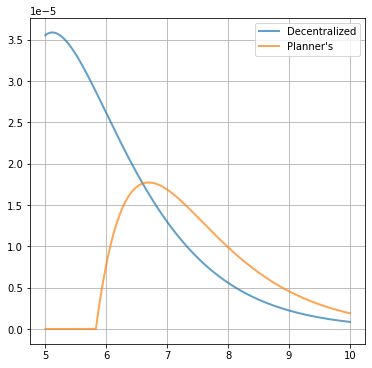

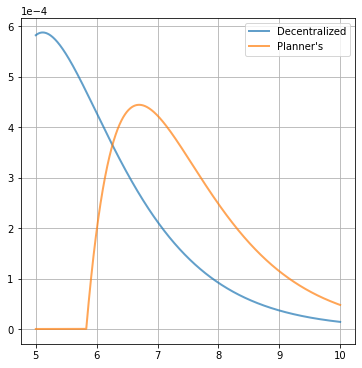

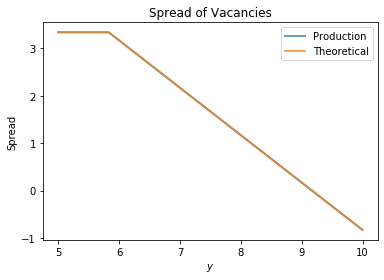

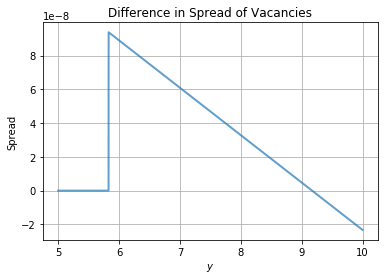

Entry from production gives 0.1719; Entry from theory gives 0.1719
unemployment in model is 0.2005; according to LOM, should be 0.2005
Employees match w/prob 0.12, employers match w/prob 0.75


In [71]:
# B = 0.95
# r = 1 / B - 1
# b = 0
# delta = 0.03
# eta = 0.5
# # phi = 1
# phi = 5e-1 
# # y_min = 1
# y_min = 8
# y_max = 10
# # This eq for k not working exact like it should. Why?
# # k = (1 - eta) * (y_max - b) / ((r + delta) * .00012 ** gamma + phi ** 2 * eta * .00012 * 2)
# # k = 5000000
# k = 5e5
# # print(phi, phi**2, k)
# y_grid_size = 4000
# # y_grid_size = 100
# gamma = 2

B = 0.95
r = 1 / B - 1
delta = 0.03
eta = 0.5
phi = 5e-1 
y_min = 5
y_max = 10
b = y_min * .4
y_grid_size = 4000

gamma = 2
# k_grid = np.logspace(4.25, 5.75, y_grid_size)
# k_grid = np.logspace(5.1, 5.9, y_grid_size)
# k_grid = np.logspace(5, 7, y_grid_size)
k_grid = np.logspace(4.5, 7, y_grid_size)

bl = BaselineDiscrete(B, b, delta, eta, phi, y_min, y_max, y_grid_size, gamma, k_grid)

iterate, wages = operator_factory(bl)

v_grid, u = solve_model(bl, tol=1e-8, verbose=False, print_skip=1e3, max_iter=1e5, slow=1e-3)

theta = np.sum(v_grid) / u
n_grid = (bl.q(theta) * v_grid) / delta
u_test = 1 - np.sum(n_grid)
# print(f"u test is {u_test}", theta, bl.q(theta))

tol = 1e-8
max_iter = 1e5
verbose = True
ps = 1e4
slow = 1e-3

guess = [v_grid, u]

v_grid_p, u_p = solve_p_model(bl, guess, tol=tol, max_iter=max_iter, slow=slow, verbose=verbose, print_skip=ps)

theta_p = np.sum(v_grid_p) / u_p
n_grid_p = v_grid_p * bl.q(theta_p) / delta

print(f"Decentralized u is {u:.3f}, Planner's u is {u_p}")

# Plot v_grids
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(bl.y_grid, v_grid, lw=2, alpha=0.7, label='Decentralized')
ax.plot(bl.y_grid, v_grid_p, lw=2, alpha=0.7, label="Planner's")
ax.ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
ax.grid()
ax.legend(loc='best')

plt.show()

# Plot n_grids
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(bl.y_grid, n_grid, lw=2, alpha=0.7, label='Decentralized')
ax.plot(bl.y_grid, n_grid_p, lw=2, alpha=0.7, label="Planner's")
ax.ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
ax.grid()
ax.legend(loc='best')

plt.show()

p_spread(bl, v_grid_p, u_p)

p_entry(bl, v_grid_p, u_p)

In [22]:
n_grid_new = np.linspace(1, 3, 5)
max(1 - np.sum(n_grid_new), 1e-5)

1e-05

In [59]:
%debug

> <ipython-input-55-6d1ae278c55b>(97)p_spread()
     95     theta = np.sum(v_grid) / u
     96 
---> 97     spread_prod = (c(v_grid[-1], gamma, k_grid[-1]) - c(v_grid, gamma, k_grid)) * (r + delta) / q(theta)
     98     spread_theory = (y_grid[-1] - y_grid)
     99     spread_theory[v_grid == 0] = spread_prod[v_grid == 0]

ipdb> v_grid[-1]
3.700694618102519e-05
ipdb> k_grid[-1]
*** TypeError: 'float' object is not subscriptable
ipdb> k_grid
1500.0
ipdb> c


In [2]:
# Old version of code, slightly different notation
# Create a baseline version of the model following L+S pg 953

import numpy as np
from interpolation import interp
import matplotlib.pyplot as plt
import quantecon as qe
from numba import njit, prange, vectorize
from scipy import optimize
from IPython.core.debugger import set_trace

# Want to vectorize cost of vacancy, marginal cost of vacancy, and inverse marginal cost of vacancy

# See if we can raise q(theta)k
@vectorize
def C(v, gamma=2, k=1):
    return k * v**gamma

@vectorize
def c(v, gamma=2, k=1):
    if v > 0:
        return k * gamma * v**(gamma - 1)
    else:
        return 0
     
@vectorize
def c_inv(c, gamma=2, k=1):
    if c > 0:
        return (c / gamma / k)**(1 / (gamma - 1))
    else:
        return 0
    
# Set up the baseline environment, starting with a discrete model
# For now, have entry costs be exponential, matching probability be q=phi * theta**(1 / 2) 
class BaselineDiscrete:
    """
    B is discount rate beta
    r is interest rate defined by beta
    b is home production
    delta is job loss rate
    eta is worker bargaining power    
    phi is effectiveness of matching function
    q is firm's matching function, worker's is p=theta*q(theta)
    y_min, y_max, y_grid_size determine productivity grid
    gamma is steepness of marginal cost
    q is matching function of firms
    p is matching function of workers
    """
    def __init__(self, B, b, delta, eta, phi, y_min, y_max, y_grid_size, gamma, k):
        
        self.B, self.b, self.delta, self.eta, self.gamma, self.k = B, b, delta, eta, gamma, k
        self.r = 1 / B - 1
        
        self.y_grid = np.linspace(y_min, y_max, y_grid_size)
        self.y_grid_size = y_grid_size        
        
        self.q = njit(lambda x: min(phi * x**(-1 / 2), 1))
        self.p = njit(lambda x: min(phi * x**(1 / 2), 1))
        self.q_p = njit(lambda x: -phi / 2 * x**(-3 / 2))
        
        
# Set up functions of problem
def operator_factory(bl):
    "Use a baseline case bl and create a function to find next vacancy and unemployment iterations"
    
    B, r, b, delta, eta, gamma, k = bl.B, bl.r, bl.b, bl.delta, bl.eta, bl.gamma, bl.k
    y_grid, y_grid_size = bl.y_grid, bl.y_grid_size
    q, p = bl.q, bl.p
    
    # Use v_grid and u to find theta and f_grid (make sure v not 0)
    @njit()
    def get_dist(v_grid, u):
        v = max(np.sum(v_grid), 1e-8)
        f_grid = v_grid / v
        theta = v / u
        return theta, f_grid
    
    # Find wages for each postion
    @njit()
    def wages(v_grid, theta, f_grid):
        return b + eta * (y_grid - b + theta * np.sum(c(v_grid, gamma, k) * f_grid))
    
    # Find next v_grid and u
    @njit()
    def iterate(v_grid, u):  

        theta, f_grid = get_dist(v_grid, u)

        w_grid = wages(v_grid, theta, f_grid)

        # Use w_grid to find out how many of firm i wants to enter (cannot be below 0)
        v_grid_new = c_inv(q(theta) * (y_grid - w_grid) / (r + delta), gamma, k)
        
#         # Update u_new using steady state rule
#         u_new = delta / (delta + p(theta))

        # Try updating u_new using unemployed workers
        n_grid_new = q(theta) * v_grid_new / delta
        u_new = max(1 - np.sum(n_grid_new), 1e-5)
        
        return v_grid_new, u_new 
    
    return iterate, get_dist, wages

def solve_model(bl, tol=1e-4, max_iter=1000, verbose=True, print_skip=25, slow=1/100):
    
    iterate, get_dist, wages = operator_factory(bl)
    
    # Set up initial guesses and loop parameters
    v_grid = np.ones(bl.y_grid_size) / bl.y_grid_size
    u = 0.05
    i = 0
    err = tol + 1    
    
    # Update v_grid and u each period
    while i < max_iter and err > tol:
        v_grid_new, u_new = iterate(v_grid, u)
        err_v = np.max(np.abs(v_grid_new - v_grid))
        err_u = np.abs(u_new - u)
        err = max(err_v, err_u)
        i += 1
        
        if verbose and i % print_skip == 0:
            print(f'Error at iter {i} is {err}')
#             theta, f_grid = get_dist(v_grid_new, u_new)
#             print(u, theta, bl.q(theta), bl.p(theta), delta / (delta + bl.p(theta)))
            
#         if verbose and i % print_skip == 1:
#             print(f'Error at iter {i} is {err}')
#             theta, f_grid = get_dist(v_grid_new, u_new)
#             print(u, theta, bl.q(theta), bl.p(theta), delta / (delta + bl.p(theta)))  
        
#         if verbose and i >= 0 and i <= 5:
#             print(f'Error at iter {i} is {err}')
#             theta, f_grid = get_dist(v_grid_new, u_new)
#             print(u, theta, bl.q(theta), bl.p(theta), delta / (delta + bl.p(theta)))  
#             print(u_new, v_grid_new) 
        
        v_grid, u = slow * v_grid_new + (1 - slow) * v_grid, slow * u_new + (1 - slow) * u
        
    if i == max_iter:
        print("Failed to Converge")
        
    if verbose and i < max_iter:
        print(f'Converged in {i} iterations')
    
    return v_grid_new, u_new

# Can check code against theoretical results by looking at spread and number of entrants
# For spread of entrants, compare each firms entry to highest. Graph results
# Keep in mind that spread_theory doesn't know that vacancies cannot be negative
def spread(bl, v_grid, u,
           save=False, folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures', file='\Baseline\Spread'):
    
    gamma, k, eta, r, delta = bl.gamma, bl.k, bl.eta, bl.r, bl.delta
    q, y_grid = bl.q, bl.y_grid
    
    iterate, get_dist, wages = operator_factory(bl)
    theta, f_grid = get_dist(v_grid, u)
    
    spread_prod = (c(v_grid[-1], gamma, k) - c(v_grid, gamma, k)) * (r + delta) / ((1 - eta) * q(theta))
    spread_theory = (y_grid[-1] - y_grid) 
    spread_theory[v_grid == 0] = spread_prod[v_grid == 0]
    dif = spread_theory - spread_prod
    
    fig, ax = plt.subplots()
    ax.plot(y_grid, spread_prod, lw=2, alpha=0.7, label='Production')
    ax.plot(y_grid, spread_theory, lw=2, alpha=0.7, label='Theoretical')
    ax.set(xlabel='$y$', ylabel='Spread', title='Spread of Vacancies')
    ax.legend(loc='best')
    ax.grid()
    
    if save:
        fig.savefig(folder + file)
    else:
        plt.show()   
        
    fig, ax = plt.subplots()
    ax.plot(y_grid, dif, lw=2, alpha=0.7)
    ax.set(xlabel='$y$', ylabel='Spread', title='Difference in Spread of Vacancies')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '_dif')
    else:
        plt.show()  

# For number of vacancies, just have two numbers to compare
def entry(bl, v_grid, u):
    
    b, gamma, k, eta, r, delta = bl.b, bl.gamma, bl.k, bl.eta, bl.r, bl.delta
    q, p, y_grid = bl.q, bl.p, bl.y_grid
    
    iterate, get_dist, wages = operator_factory(bl)
    theta, f_grid = get_dist(v_grid, u)
    
    entry_theory = np.sum(v_grid * (y_grid - b))
    entry_code = (r + delta + eta * theta * q(theta)) * np.sum(v_grid * c(v_grid, gamma, k)) / ((1 - eta) * q(theta))
    
    print(f'Entry from code gives {entry_code:.4f}; Entry from theory gives {entry_theory:.4f}')
    
    # While doing this, also check if u is consistent with LOM
    u_t = delta / (delta + p(theta))    
    print(f'unemployment in model is {u:.4f}; according to LOM, should be {u_t:.4f}')
    # Probably related to whether p and q are < 1. Check these
    print(f'Employees match w/prob {p(theta):.2f}, employers match w/prob {q(theta):.2f}')

Error at iter 1000 is 0.3496603138462625
Error at iter 2000 is 0.5869286461713292
Error at iter 3000 is 0.1935496255664345
Error at iter 4000 is 0.050622110914699786
Error at iter 5000 is 0.0154199930320848
Error at iter 6000 is 0.005050576903428666
Error at iter 7000 is 0.001717542102041572
Error at iter 8000 is 0.0005927962493902372
Error at iter 9000 is 0.0002054983323424575
Error at iter 10000 is 7.125552236487975e-05
Error at iter 11000 is 2.4673667527827514e-05
Error at iter 12000 is 8.525958359650865e-06
Error at iter 13000 is 2.9387547171716433e-06
Error at iter 14000 is 1.010046002072884e-06
Error at iter 15000 is 3.460333270616234e-07
Error at iter 16000 is 1.1811703436170884e-07
Error at iter 17000 is 4.01522476101146e-08
Error at iter 18000 is 1.3584697228230525e-08
Converged in 18282 iterations
0.0699605329539934 0.44181101193582895 0.9026782582676676 0.39881319473770976
Entry from code gives 0.1918; Entry from theory gives 0.1918
unemployment in model is 0.0700; according

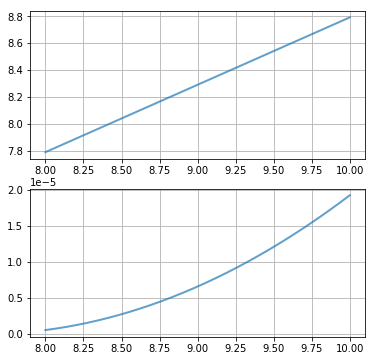

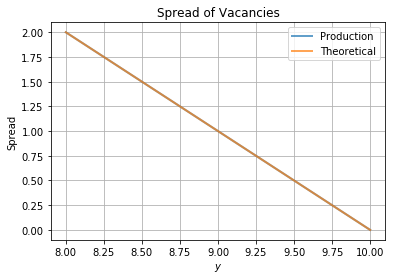

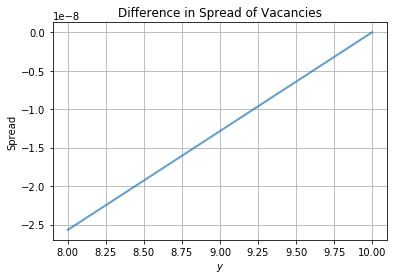

In [6]:
B = 0.95
r = 1 / B - 1
delta = 0.03
eta = 0.5
# phi = 1
u_set = 0.05
phi = 6e-1 
# y_min = 1
y_min = 8
y_max = 10
b = y_min * .4 
# This eq for k not working exact like it should. Why?
# k = (1 - eta) * (y_max - b) / ((r + delta) * .00012 ** gamma + phi ** 2 * eta * .00012 * 2)
k = 1.5e3
# k = 7e5
# print(phi, phi**2, k)
y_grid_size = 4000
# y_grid_size = 100
# gamma = 2
gamma = 1.5

bl = BaselineDiscrete(B, b, delta, eta, phi, y_min, y_max, y_grid_size, gamma, k)

iterate, get_dist, wages = operator_factory(bl)
v_grid, u = solve_model(bl, tol=1e-8, print_skip=1e3, max_iter=1e5, slow=1e-3)

theta, f_grid = get_dist(v_grid, u)
w_grid = wages(v_grid, theta, f_grid)

print(u, theta, bl.q(theta), bl.p(theta))
# print(np.sum(c(v_grid, gamma) * f_grid))
# print(np.sum(v_grid))


entry(bl, v_grid, u)
# print(v_grid)
# print(w_grid)

# Plot v_grid and w_grid
fig, axes = plt.subplots(2, figsize=(6,6))
axes[0].plot(bl.y_grid, w_grid, lw=2, alpha=0.7)
axes[0].grid()
axes[1].plot(bl.y_grid, v_grid, lw=2, alpha=0.7)
axes[1].ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
axes[1].grid()

plt.show()

spread(bl, v_grid, u)

In [3]:
# Old version of the code, slightly different notation
# Run top cell first
# Now solve the baseline Planner's Problem. Takes the same baseline discrete class.
# Try to calculate shadow cost of a vacancy for every type and use this to determine optimal amount

def p_operator_factor(bl):
    "Use a baseline case bl and create a function to update Lagrange multipliers and solve planner's problem"
    
    B, r, b, delta, eta, gamma = bl.B, bl.r, bl.b, bl.delta, bl.eta, bl.gamma
    y_grid, y_grid_size = bl.y_grid, bl.y_grid_size
    q, q_p, p = bl.q, bl.q_p, bl.p
    
    # Use v_grid and n_grid to find u and theta
    @njit()
    def p_get_dist(v_grid, n_grid):
        u = max(1 - np.sum(n_grid), 1e-6)
        theta = max(np.sum(v_grid), 1e-6) / u
        return u, theta
    
    # lam is the Lagrangian on each firm. Needs to be estimated each time    
    # Find all lam through iteration
    @njit()
    def find_lam(v_grid, u, theta, lam, tol_l=1e-4, max_iter_l=1000, slow_l=1e-2):       
        i = 0
        err = tol_l + 1
#         lam = np.ones(y_grid_size)
        while i < max_iter_l and err > tol_l:
            lam_new = (y_grid - b + (theta * q_p(theta) / u) * np.sum(v_grid * lam)) / (r + delta)
            err = np.max(np.abs(lam_new - lam))
            i += 1
            lam = slow_l * lam_new + (1 - slow_l) * lam
        
        return lam_new
    
    # update v_grid and n_grid
    @njit()
    def update_grids(v_grid, n_grid, lam, tol_l, max_iter_l, slow=1, slow_l=1e-2):
        
        u, theta = p_get_dist(v_grid, n_grid)
        
        lam_new = find_lam(v_grid, u, theta, lam, tol_l, max_iter_l, slow_l)
        
        # Given a lam_new, repeatedly update v_grid and n_grid hopefully will be faster
        for j in range(1000):        
            v_grid_new = c_inv(lam_new * q(theta) + ((q_p(theta) / u) * np.sum(v_grid * lam_new)), gamma, k)
            
            n_grid_new = q(theta) * v_grid_new / delta
            
            v_grid = v_grid_new * slow + v_grid * (1 - slow)            
            n_grid = n_grid_new * slow + n_grid * (1 - slow)

            u, theta = p_get_dist(v_grid, n_grid)        
        
        return v_grid_new, n_grid_new, lam_new
    
    return update_grids, p_get_dist, find_lam
        
# Solve model
def solve_p_model(bl, guess, tol_l=1e-4, tol=1e-4, max_iter_l=1000, max_iter=10000, verbose=True, print_skip=25, 
                   slow=1, slow_l=1e-2):   

    update_grids, _, _ = p_operator_factor(bl)

    # Set up initial guesses and loop parameters
#     # Use intitial guess from decentralized problem
#     v_grid, u = solve_model(bl, tol=1e-8, verbose=False, print_skip=1000, max_iter=100000, slow=1/1000)
    v_grid, u = guess
    theta = np.sum(v_grid) / u
    n_grid = (bl.q(theta) * v_grid) / bl.delta
    
    # Carry around lam to make re-estimating faster
    lam = (bl.y_grid - bl.b) / (bl.r + bl.delta)
    
    i = 0
    err = tol + 1 
    
    # Update v_grid, n_grid, and lamda each period
    while i < max_iter and err > tol:
        v_grid_new, n_grid_new, lam_new = update_grids(v_grid, n_grid, lam, tol_l, max_iter_l, slow, slow_l)
        err_v = np.max(np.abs(v_grid_new - v_grid))
        err_n = np.max(np.abs(n_grid_new - n_grid))
        err = max(err_v, err_n)
        i += 1
        
        if verbose and i % print_skip == 0:
            print(f'Error at iter {i} is {err}')
            print(v_grid[-1])
            
        if verbose and i % print_skip == 1:
            print(f'Error at iter {i} is {err}')
            print(v_grid[-1]) 
        
        if verbose and i >= 0 and i <= 5:
            print(f'Error at iter {i} is {err}')
            print(v_grid[-1])
        
        v_grid, n_grid = v_grid_new * slow + v_grid * (1 - slow), n_grid_new * slow + n_grid * (1 - slow)
        lam = lam_new * slow + lam * (1 - slow)
        
        
    if i == max_iter:
        print("Failed to Converge")
        
    if verbose and i < max_iter:
        print(f'Converged in {i} iterations')
    
    return v_grid_new, n_grid_new
    
# Can check code against theoretical results by looking at spread and number of entrants
# For spread of entrants, compare each firms entry to highest. Graph results
# Keep in mind that spread_theory doesn't know that vacancies cannot be negative
def p_spread(bl, v_grid, n_grid,
           save=False, folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures', file='\Baseline\Planner_Spread'):
    
    gamma, k, eta, r, delta = bl.gamma, bl.k, bl.eta, bl.r, bl.delta
    q, y_grid = bl.q, bl.y_grid
        
    theta = np.sum(v_grid) / (1 - np.sum(n_grid))
    
    spread_prod = (c(v_grid[-1], gamma, k) - c(v_grid, gamma, k)) * (r + delta) / q(theta)
    spread_theory = (y_grid[-1] - y_grid) 
    spread_theory[v_grid == 0] = spread_prod[v_grid == 0]
    dif = spread_theory - spread_prod
    
    fig, ax = plt.subplots()
    ax.plot(y_grid, spread_prod, lw=2, alpha=0.7, label='Production')
    ax.plot(y_grid, spread_theory, lw=2, alpha=0.7, label='Theoretical')
    ax.set(xlabel='$y$', ylabel='Spread', title='Spread of Vacancies')
    ax.legend(loc='best')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
    
    if save:
        fig.savefig(folder + file)
    else:
        plt.show()   
        
    fig, ax = plt.subplots()
    ax.plot(y_grid, dif, lw=2, alpha=0.7)
    ax.set(xlabel='$y$', ylabel='Spread', title='Difference in Spread of Vacancies')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '_dif')
    else:
        plt.show()  

# For number of vacancies, just have two numbers to compare
def p_entry(bl, v_grid, n_grid):
    
    b, gamma, k, eta, r, delta = bl.b, bl.gamma, bl.k, bl.eta, bl.r, bl.delta
    q, q_p, p, y_grid = bl.q, bl.q_p, bl.p, bl.y_grid
    
    theta = np.sum(v_grid) / (1 - np.sum(n_grid))
    alpha = -(theta * q_p(theta)) / q(theta)
    
    entry_theory = np.sum(v_grid * (y_grid - b))
    entry_prod = (r + delta + alpha * theta * q(theta)) * np.sum(v_grid * c(v_grid, gamma, k)) / ((1 - alpha) * q(theta))
    
    print(f'Entry from production gives {entry_prod:.4f}; Entry from theory gives {entry_theory:.4f}')
    
    # While doing this, also check if u is consistent with LOM
    u = 1 - np.sum(n_grid)
    u_t = delta / (delta + bl.p(theta))    
    print(f'unemployment in model is {u:.4f}; according to LOM, should be {u_t:.4f}')
    # Probably related to whether p and q are < 1. Check these
    print(f'Employees match w/prob {p(theta):.2f}, employers match w/prob {q(theta):.2f}')

Error at iter 1 is 0.00046278561776832744
2.3449381649105418e-05
Error at iter 1 is 0.00046278561776832744
2.3449381649105418e-05
Error at iter 2 is 0.00045834463483101974
2.358521228805437e-05
Error at iter 3 is 0.00045394605677143705
2.3719681557361466e-05
Error at iter 4 is 0.0004495894766841146
2.385280310360919e-05
Error at iter 5 is 0.0004452744916122988
2.3984590436637546e-05
Error at iter 100 is 0.00017756003659884028
3.200268397486809e-05
Error at iter 101 is 0.00017584272184808201
3.205279882168265e-05
Error at iter 200 is 6.686422575238968e-05
3.517747900366722e-05
Error at iter 201 is 6.621122664254007e-05
3.519579201473563e-05
Error at iter 300 is 2.495694628251808e-05
3.633785723688365e-05
Error at iter 301 is 2.4711258435963562e-05
3.634455250016034e-05
Error at iter 400 is 9.25210653726291e-06
3.6762166925262185e-05
Error at iter 401 is 9.16050761828966e-06
3.6764615697169134e-05
Error at iter 500 is 3.4140072792876106e-06
3.691737630746464e-05
Error at iter 501 is 3.38

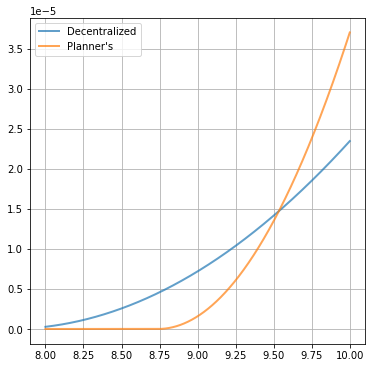

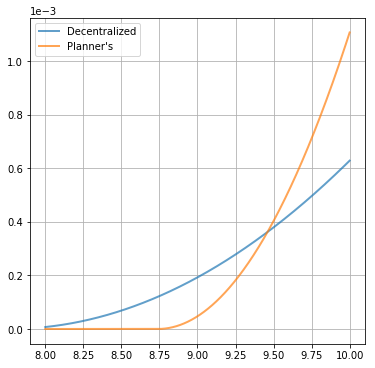

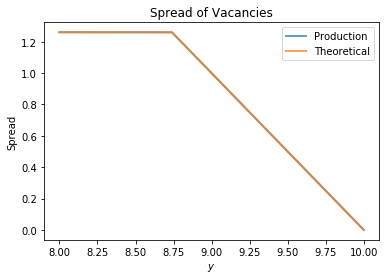

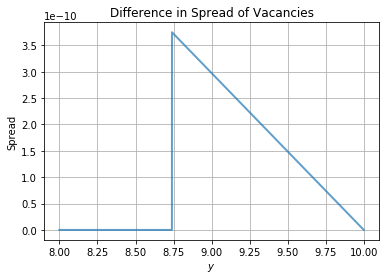

Entry from production gives 0.2018; Entry from theory gives 0.2018
unemployment in model is 0.0696; according to LOM, should be 0.0696
Employees match w/prob 0.40, employers match w/prob 0.90


In [6]:
# B = 0.95
# r = 1 / B - 1
# b = 0
# delta = 0.03
# eta = 0.5
# # phi = 1
# phi = 5e-1 
# # y_min = 1
# y_min = 8
# y_max = 10
# # This eq for k not working exact like it should. Why?
# # k = (1 - eta) * (y_max - b) / ((r + delta) * .00012 ** gamma + phi ** 2 * eta * .00012 * 2)
# # k = 5000000
# k = 5e5
# # print(phi, phi**2, k)
# y_grid_size = 4000
# # y_grid_size = 100
# gamma = 2

B = 0.95
r = 1 / B - 1
delta = 0.03
eta = 0.5
phi = 6e-1 
y_min = 8
y_max = 10
b = y_min * .4
y_grid_size = 4000
# gamma = 2
# k = 5e5

gamma = 1.5
k = 1.5e3

bl = BaselineDiscrete(B, b, delta, eta, phi, y_min, y_max, y_grid_size, gamma, k)

iterate, get_dist, wages = operator_factory(bl)

v_grid, u = solve_model(bl, tol=1e-8, verbose=False, print_skip=1e3, max_iter=1e5, slow=1e-3)

theta = np.sum(v_grid) / u
n_grid = (bl.q(theta) * v_grid) / delta
u_test = 1 - np.sum(n_grid)
# print(f"u test is {u_test}", theta, bl.q(theta))

tol = 1e-8
max_iter = 1e5
verbose = True
ps = 1e2
slow = 1e-2
slow_l = 1e-2

guess = [v_grid, u]

v_grid_p, n_grid_p = solve_p_model(bl, guess, tol_l=1e-6, tol=tol, max_iter_l=1e5,
                                    max_iter=max_iter, verbose=verbose, print_skip=ps, slow=slow, slow_l=slow_l)

u_p = 1 - np.sum(n_grid_p)
print(f"Decentralized u is {u:.3f}, Planner's u is {u_p}")

# Plot v_grids
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(bl.y_grid, v_grid, lw=2, alpha=0.7, label='Decentralized')
ax.plot(bl.y_grid, v_grid_p, lw=2, alpha=0.7, label="Planner's")
ax.ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
ax.grid()
ax.legend(loc='best')

plt.show()

# Plot n_grids
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(bl.y_grid, n_grid, lw=2, alpha=0.7, label='Decentralized')
ax.plot(bl.y_grid, n_grid_p, lw=2, alpha=0.7, label="Planner's")
ax.ticklabel_format(axis='y', style='sci', scilimits=(1,-1))
ax.grid()
ax.legend(loc='best')

plt.show()

p_spread(bl, v_grid_p, n_grid_p)

p_entry(bl, v_grid_p, n_grid_p)

In [13]:
# Instead of solving planner's problem directly, try iterating on spread and entry implied by pp
# Idea, find correct dist given v_grid
# Use spread to update v_grid[:-1]
# Use entry to update v_max

def p_operator_factor(bl):
    "Find planner's v by updating over optimal spread and entry"
    
    B, r, b, delta, eta, gamma, k = bl.B, bl.r, bl.b, bl.delta, bl.eta, bl.gamma, bl.k
    y_grid, y_grid_size, y_max = bl.y_grid, bl.y_grid_size, bl.y_grid[-1]
    q, q_p, p = bl.q, bl.q_p, bl.p
    
    # Find theta and alpha implied by v_grid and n_grid
    @njit()
    def update_dist(v_grid, n_grid, slow=1):
        theta = np.sum(v_grid) / (1 - np.sum(n_grid))
        alpha = -(theta * q_p(theta)) / q(theta)
        n_grid_temp = (q(theta) * v_grid) / delta
        n_grid_r = slow * n_grid_temp + (1 - slow) * n_grid 
        return n_grid_r, theta, alpha    
    
    # Use pp's spread to update v_grid[:-1] given v_max
    @njit()
    def update_v_spread(v_grid, theta, slow=1):
        return (slow * c_inv(c(v_grid[-1], gamma, k) - ((y_max - y_grid) * q(theta) / (r + delta)), gamma, k)
                + (1 - slow) * v_grid)
    
#     # Use pp's entry to update v_max given v_grid[:-1]
# #     @njit()
#     def update_v_max(v_grid, theta, alpha, slow=1):
#         # Use brent_q to solve for v_max.
#         def func(x):
#             front = (r + delta + (alpha * theta * q(theta))) / (q(theta) * (1 - alpha))
#             v_temp = np.copy(v_grid)
#             v_temp[-1] = x
#             return front * (np.sum(v_temp * c(v_temp, gamma, k))) - np.sum(v_temp * (y_grid - b))                   
        
#         v_max = optimize.brentq(func, 0, 1)
#         return slow * v_max + (1 - slow) * v_grid[-1]

    # Use pp's entry to update level of v_grid needed to equal previous v_grids costs. Assume spread evenly among 
    # v_grid
    @njit()
    def update_v_max(v_grid, theta, alpha, slow=1):
        front = (r + delta + (alpha * theta * q(theta))) / (q(theta) * (1 - alpha))
        x = (front * np.sum(c(v_grid, gamma, k) * v_grid) - np.sum((y_grid - b) * v_grid))
        v_temp = v_grid * (1 + x)
        return slow * v_temp + (1 - slow) * v_grid
        
    
    # Use spread and entry to find new v_grid
    @njit()
    def iterate_dist(v_grid, n_grid, slow=1):
        n_grid, theta, alpha = update_dist(v_grid, n_grid, slow)
        v_grid = update_v_spread(v_grid, theta, slow)
        n_grid, theta, alpha = update_dist(v_grid, n_grid, slow)
        v_grid = update_v_max(v_grid, theta, alpha, slow)
        
        return v_grid
    
    return update_dist, update_v_spread, update_v_max, iterate_dist

def solve_p_model(bl, tol_n=1e-2, tol=1e-4, max_iter_n=100, max_iter=1000, verbose=True, print_skip=25, slow=1/100):
    
    update_dist, _, _, iterate_dist = p_operator_factor(bl)
    
    # Set up initial guesses and loop parameters
    # Use intitial guess from decentralized problem
    v_grid, u = solve_model(bl, tol, max_iter, verbose=False)
    theta = np.sum(v_grid) / u
    n_grid = (bl.q(theta) * v_grid) / delta
    i = 0
    err = tol + 1  
    switch = 1
    
    # Update v_grid each period
    while i < max_iter and err > tol:
        # First find correct n_grid
        j = 0
        err_n = tol_n + 1
        while j < max_iter_n and err_n > tol_n:
            n_grid_new, _, _ = update_dist(v_grid, n_grid, slow)
            err_n = np.max(np.abs(n_grid - n_grid_new))
            j += 1
            n_grid = n_grid_new
        
        # Once we have the right n_grid, update v_grid 
        v_grid_new = iterate_dist(v_grid, n_grid, slow)
        err = np.max(np.abs(v_grid_new - v_grid))
        i += 1
        
        if verbose and i % print_skip == 0:
            print(f'Error at iter {i} is {err}, employed are {np.sum(n_grid):.4f}')
            
        if verbose and i % print_skip == 1:
            print(f'Error at iter {i} is {err}, employed are {np.sum(n_grid):.4f}') 
            
#         if verbose and i == 26:
#             print(f'Error at iter {i} is {err}, employed are {np.sum(n_grid):.4f}') 
            
        if verbose and np.isnan(np.sum(n_grid)) and switch == 1:
            print(f'Error at iter {i} is {err}, n_grid is nan')
            switch = 0
        
        if verbose and i >= 0 and i <= 5:
            print(f'Error at iter {i} is {err}, employed are {np.sum(n_grid):.4f}') 
        
        v_grid = v_grid_new
        
    # Once converged, use n_grid to find u
    u_new = 1 - np.sum(n_grid_new)
    print(n_grid_new[0], n_grid_new[-1], np.sum(n_grid_new))
        
    if i == max_iter:
        print("Failed to Converge")
        
    if verbose and i < max_iter:
        print(f'Converged in {i} iterations')
    
    return v_grid_new, u_new

Error at iter 100 is 0.0035124315576724463
Error at iter 200 is 0.0012856635466168553
Error at iter 300 is 4.071916224490657e-05
Error at iter 400 is 0.0014991754473796526
Error at iter 500 is 0.0008480552754068782
Error at iter 600 is 0.00037342087077896213
Error at iter 700 is 0.00015155365824159883
Error at iter 800 is 5.918936734916613e-05
Error at iter 900 is 2.2619184337102638e-05
Error at iter 1000 is 8.527643764355552e-06
Error at iter 1100 is 3.186483768624626e-06
Error at iter 1200 is 1.1834849230618616e-06
Error at iter 1300 is 4.377103436370433e-07
Error at iter 1400 is 1.614083461332072e-07
Error at iter 1500 is 5.939554303946437e-08
Error at iter 1600 is 2.1823871820814134e-08
Converged in 1678 iterations
0.38652192460427637
Error at iter 1 is 3.125031705773557e-08, employed are 0.3865
Error at iter 1 is 3.125031705773557e-08, employed are 0.3865
Error at iter 2 is 3.091116438039513e-08, employed are 0.3864
Error at iter 3 is 3.057330306643661e-08, employed are 0.3841
Err

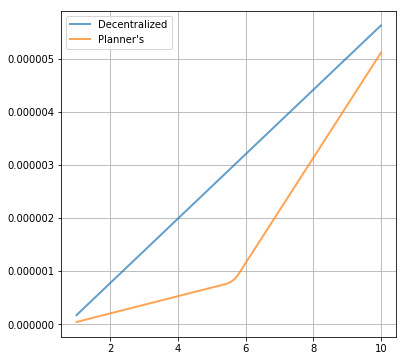

In [46]:
B = 0.95
r = 1 / B - 1
b = 0
delta = 0.03
eta = 0.5
# phi = 1
u_set = 0.05
phi = np.sqrt(delta / u_set - delta) 
y_min = 1
y_max = 10
# This eq for k not working exact like it should. Why?
# k = (1 - eta) * (y_max - b) / ((r + delta) * .00012 ** gamma + phi ** 2 * eta * .00012 * 2)
k = 5000000
# print(phi, phi**2, k)
y_grid_size = 4000
gamma = 2

bl = BaselineDiscrete(B, b, delta, eta, phi, y_min, y_max, y_grid_size, gamma, k)

iterate, get_dist, wages = operator_factory(bl)

tol = 1e-8
max_iter = 10000
verbose = True
ps = 100
slow = 1/100
v_grid, u = solve_model(bl, tol=tol, max_iter=max_iter, verbose=verbose, print_skip=ps, slow=slow)

theta = np.sum(v_grid) / u
n_grid = (bl.q(theta) * v_grid) / delta
u_test = 1 - np.sum(n_grid)
# print(f"u test is {u_test}", theta, bl.q(theta))

v_grid_p, u_p = solve_p_model(bl, tol_n=1e-8, tol=tol, max_iter_n=10000,
                               max_iter=max_iter, verbose=verbose, print_skip=ps, slow=slow)
print(f"Decentralized u is {u:.3f}, Planners u is {u_p}")


# Plot v_grids
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(bl.y_grid, v_grid, lw=2, alpha=0.7, label='Decentralized')
ax.plot(bl.y_grid, v_grid_p, lw=2, alpha=0.7, label="Planner's")
ax.grid()
ax.legend(loc='best')

plt.show()

0.055982303666500643


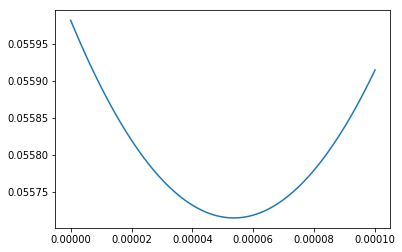

In [105]:
theta = np.sum(v_grid) / (1 - np.sum(n_grid))
alpha = -(theta * bl.q_p(theta)) / bl.q(theta)

def func(x):
    front = (r + delta + (alpha * theta * bl.q(theta))) / (bl.q(theta) * (1 - alpha))
    v_temp = v_grid[:-1]
    y_temp = bl.y_grid[:-1]
    return (front * (np.sum(v_temp * c(v_temp, gamma, k)) + x * c(x, gamma, k))
           - (np.sum(v_temp * (y_temp - b)) + x * (bl.y_grid[-1] - b)))

x_grid = np.linspace(0, 1e-4, 100)

print(func(0))

plt.plot(x_grid, func(x_grid))
plt.show()

In [14]:
%debug

> c:\users\spspi\anaconda3\lib\site-packages\scipy\optimize\zeros.py(510)brentq()
    508     if rtol < _rtol:
    509         raise ValueError("rtol too small (%g < %g)" % (rtol, _rtol))
--> 510     r = _zeros._brentq(f,a,b,xtol,rtol,maxiter,args,full_output,disp)
    511     return results_c(full_output, r)
    512 

ipdb> u
> <ipython-input-12-269a9fd8db9f>(39)update_v_max()
     37                    - (np.sum(v_temp * (y_temp - b)) + x * (y_grid[-1] - b)))
     38 
---> 39         v_max = optimize.brentq(func, 0, 1)
     40         return slow * v_max + (1 - slow) * v_grid[-1]
     41 

ipdb> func(0)
-0.07651334149935282
ipdb> func(1e-6)
-0.07652384859574951
ipdb> c


0.04890759655570254 0.0489059612405629
0.5971204307285769 0.5971204307285773 0.5971403972123317
9.588822328689128e-08
alpha = 0.49999999999999994
0.9770267677951293


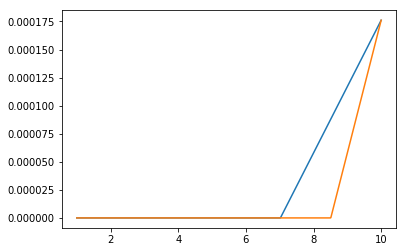

0.2993743741460073 1.0
1.0275708683113138
167.00169331927424 0.05842207668943143


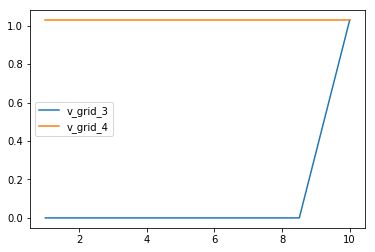

In [47]:
B = 0.95
r = 1 / B - 1
b = 0
delta = 0.03
eta = 0.5
# phi = 1
u_set = 0.05
phi = np.sqrt(delta / u_set - delta) 
y_min = 1
y_max = 10
# This eq for k not working exact like it should. Why?
# k = (1 - eta) * (y_max - b) / ((r + delta) * .00012 ** gamma + phi ** 2 * eta * .00012 * 2)
k = 50000
# print(phi, phi**2, k)
y_grid_size = 1000
gamma = 2

bl = BaselineDiscrete(B, b, delta, eta, phi, y_min, y_max, y_grid_size, gamma, k)

iterate, get_dist, wages = operator_factory(bl)

tol = 1e-8
max_iter = 100000
verbose = False
ps = 100
v_grid, u = solve_model(bl, tol=tol, max_iter=max_iter, verbose=verbose, print_skip=ps)

theta_3, f_grid = get_dist(v_grid, u)

theta = np.sum(v_grid) / u
n_grid = (bl.q(theta) * v_grid) / delta
u_test = 1 - np.sum(n_grid)
print(u, u_test)

update_dist, update_v_spread, update_v_max, iterate_dist = p_operator_factor(bl)

n_grid_2, theta_2, alpha = update_dist(v_grid, n_grid, slow=1)
print(theta_3, theta, theta_2)
print(max(n_grid - n_grid_2))
print(f"alpha = {alpha}")
print(bl.q(theta))

v_grid_2 = update_v_spread(v_grid, theta, slow=1)

plt.plot(bl.y_grid, v_grid, label='v_grid')
plt.plot(bl.y_grid, v_grid_2, label='v_grid_2')
plt.show()

n_grid_3, theta_3, alpha_2 = update_dist(v_grid_2, n_grid_2, slow=1)
print(theta_3, bl.q(theta_3))

v_grid_3 = update_v_max(n_grid_3, theta_3, alpha_2, slow=1)
print(max(v_grid_3 - v_grid_2))

n_grid_4, theta_4, alpha_3 = update_dist(v_grid_3, n_grid_3, slow=1)
print(theta_4, bl.q(theta_4))

v_grid_4 = update_v_spread(v_grid_3, theta_4, slow=1)

plt.plot(bl.y_grid, v_grid_3, label='v_grid_3')
plt.plot(bl.y_grid, v_grid_4, label='v_grid_4')
plt.legend()
plt.show()

In [97]:
%debug

> c:\users\spspi\anaconda3\lib\site-packages\scipy\optimize\zeros.py(510)brentq()
    508     if rtol < _rtol:
    509         raise ValueError("rtol too small (%g < %g)" % (rtol, _rtol))
--> 510     r = _zeros._brentq(f,a,b,xtol,rtol,maxiter,args,full_output,disp)
    511     return results_c(full_output, r)
    512 

ipdb> u
> <ipython-input-83-956db2bcc0e4>(39)update_v_max()
     37 
     38 
---> 39         v_max = optimize.brentq(func, 0, 1)
     40         return slow * v_max + (1 - slow) * v_grid[-1]
     41 

ipdb> func(0)
170.92076981839463
ipdb> func(1)
93420.29239578926
ipdb> c


In [ ]:
# Try to solve baseline planner's problem. 
# Strategy here to create grid of multiple potential n_grid where n_i <= n_{i+1} and sum(n_grid) < 1
# For each n_grid, find implied v_grid (if it exists/ is feasible)
# Then take steady state planner's utility of each n_grid, find max

def p_operator_factor(bl):
    "Use a baseline case bl and create a function to update Planner's value function P"
    
    B, r, b, delta, eta, alpha = bl.B, bl.r, bl.b, bl.delta, bl.eta, bl.alpha
    y_grid, y_grid_size = bl.y_grid, bl.y_grid_size
    n_c_grid, n_c_grid_size = bl.n_c_grid, bl.n_c_grid_size
    q, q_p, p = bl.q, bl.q_p, bl.p
    
    # Create set of n_grid 
    def create_n_set():
        # each row of n_set is a potential n_grid
        n_set = np.empty((np.math.factorial(n_c_grid_size), n_c_grid_size))

1.312053541947634 0.6591156882802855


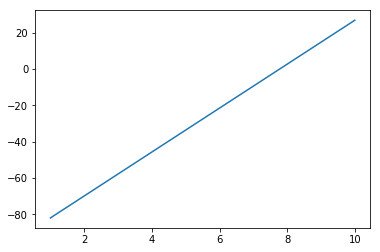

0.27754889124176507 1.0
44472.30031746912 0.0035800791715350556


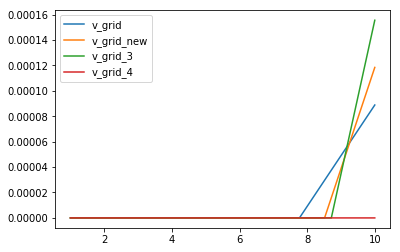

In [36]:
update_grids, p_get_dist, find_lam = p_operator_factor(bl)

# v_grid, u = solve_model(bl, tol=1e-8, verbose=False, print_skip=1000, max_iter=100000, slow=1/1000)
theta = np.sum(v_grid) / u
print(theta, bl.q(theta))

# lam_1 = np.ones(y_grid_size)
      
# lam_2 = (bl.y_grid - b + (theta * bl.q_p(theta) / u) * np.sum(v_grid * lam_1)) / (r + delta)

# lam_3 = (bl.y_grid - b + (theta * bl.q_p(theta) / u) * np.sum(v_grid * lam_2)) / (r + delta)

# lam_4 = (bl.y_grid - b + (theta * bl.q_p(theta) / u) * np.sum(v_grid * lam_3)) / (r + delta)

# plt.plot(bl.y_grid, lam_2, label='lam_2')
# plt.plot(bl.y_grid, lam_3, label='lam_3')
# plt.plot(bl.y_grid, lam_4, label='lam_4')
# plt.legend()
# plt.show()

lam = find_lam(v_grid, u, theta, tol_l=1e-4, max_iter_l=1000, slow_l=1/100)

plt.plot(bl.y_grid, lam)
plt.show()

# cost = lam * bl.q(theta) + ((bl.q_p(theta) / u) * np.sum(v_grid * lam))

# plt.plot(bl.y_grid, cost)
# plt.show()

v_grid_new = c_inv(lam * bl.q(theta) + ((bl.q_p(theta) / u) * np.sum(v_grid * lam)), gamma, k)

# plt.plot(bl.y_grid, v_grid, label='v_grid')
# plt.plot(bl.y_grid, v_grid_new, label='v_grid_new')
# plt.legend()
# plt.show()

n_grid_new = bl.q(theta) * v_grid_new / delta
u_new = max(1 - np.sum(n_grid_new), 1e-6)
theta_new = np.sum(v_grid_new) / u_new
print(theta_new, bl.q(theta_new))

lam_2 = find_lam(v_grid_new, u_new, theta_new, tol_l=1e-4, max_iter_l=1001, slow_l=1/100)

v_grid_3 = c_inv(lam_2 * bl.q(theta_new) + ((bl.q_p(theta_new) / u_new) * np.sum(v_grid_new * lam_2)), gamma, k)

n_grid_3 = bl.q(theta_new) * v_grid_3 / delta
u_3 = max(1 - np.sum(n_grid_3), 1e-6)
theta_3 = np.sum(v_grid_3) / u_3
print(theta_3, bl.q(theta_3))

lam_3 = find_lam(v_grid_3, u_3, theta_3, tol_l=1e-4, max_iter_l=1001, slow_l=1/100)

v_grid_4 = c_inv(lam_3 * bl.q(theta_3) + ((bl.q_p(theta_3) / u_3) * np.sum(v_grid_3 * lam_3)), gamma, k)

plt.plot(bl.y_grid, v_grid, label='v_grid')
plt.plot(bl.y_grid, v_grid_new, label='v_grid_new')
plt.plot(bl.y_grid, v_grid_3, label='v_grid_3')
plt.plot(bl.y_grid, v_grid_4, label='v_grid_4')
plt.legend()
plt.show()

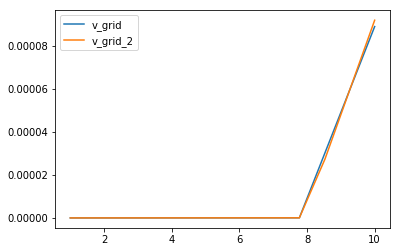

In [42]:
v_grid, u = solve_model(bl, tol=1e-8, verbose=False, print_skip=1000, max_iter=100000, slow=1/1000)
theta = np.sum(v_grid) / u
n_grid = bl.q(theta) * v_grid / delta

update_grids, p_get_dist, find_lam = p_operator_factor(bl)

tol_l = 1e-4
max_iter_l = 1000
slow = 1 / 10
slow_l = 1 / 100

v_grid_2, n_grid_2 = update_grids(v_grid, n_grid, tol_l, max_iter_l, slow_l)
v_grid_2, n_grid_2 = v_grid_2 * slow + v_grid * (1 - slow), n_grid_2 * slow + n_grid * (1 - slow)

v_grid_3, n_grid_3 = update_grids(v_grid_2, n_grid_2, tol_l, max_iter_l, slow_l)
v_grid_3, n_grid_3 = v_grid_3 * slow + v_grid_2 * (1 - slow), n_grid_3 * slow + n_grid_2 * (1 - slow)

v_grid_4, n_grid_4 = update_grids(v_grid_3, n_grid_3, tol_l, max_iter_l, slow_l)
v_grid_4, n_grid_4 = v_grid_4 * slow + v_grid_3 * (1 - slow), n_grid_4 * slow + n_grid_3 * (1 - slow)

plt.plot(bl.y_grid, v_grid, label='v_grid')
plt.plot(bl.y_grid, v_grid_2, label='v_grid_2')
# plt.plot(bl.y_grid, v_grid_3, label='v_grid_3')
# plt.plot(bl.y_grid, v_grid_4, label='v_grid_4')
plt.legend()
plt.show()

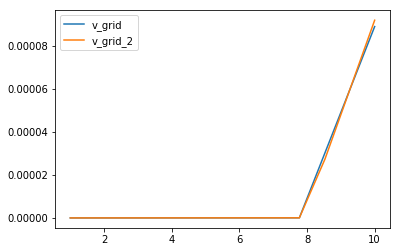

In [44]:
update_grids, _, _ = p_operator_factor(bl)

# Set up initial guesses and loop parameters
# Use intitial guess from decentralized problem
# v_grid, u = solve_model(bl, tol, max_iter, verbose=False)
v_grid, u = solve_model(bl, tol=1e-8, verbose=False, print_skip=1000, max_iter=100000, slow=1/1000)
theta = np.sum(v_grid) / u
n_grid = (bl.q(theta) * v_grid) / delta
i = 0
err = tol + 1 

v_grid_new, n_grid_new = update_grids(v_grid, n_grid, tol_l, max_iter_l, slow_l)
err_v = np.max(np.abs(v_grid_new - v_grid))
err_n = np.max(np.abs(n_grid_new - n_grid))
err = max(err_v, err_n)
i += 1

v_grid_2, n_grid_2 = v_grid_new * slow + v_grid * (1 - slow), n_grid_new * slow + n_grid * (1 - slow)

plt.plot(bl.y_grid, v_grid, label='v_grid')
plt.plot(bl.y_grid, v_grid_2, label='v_grid_2')
plt.legend()
plt.show()

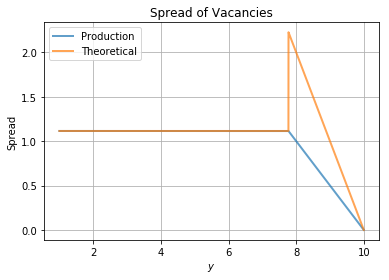

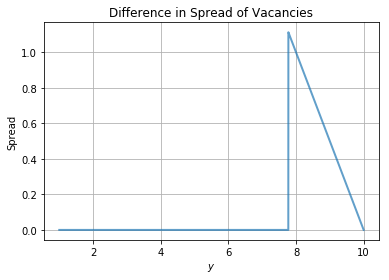

Entry from production gives 0.4077; Entry from theory gives 0.4073
unemployment in model is 0.0335; according to LOM, should be 0.0335


In [8]:
p_spread(bl, v_grid, n_grid)

p_entry(bl, v_grid, n_grid)

In [39]:
# Create a baseline version of the model following L+S pg 953
# First try, doesn't work if v ever equals 0, because fluctuates back and forth too much
# Kept in case need later
        
def operator_factory(bl):
    "Use a baseline case bl and create a function to find next vacancy and unemployment iterations"
    
    B, r, b, delta, eta, alpha = bl.B, bl.r, bl.b, bl.delta, bl.eta, bl.alpha
    y_grid, y_grid_size = bl.y_grid, bl.y_grid_size
    q, p = bl.q, bl.p
    
    # Use v_grid and u to find theta and f_grid (make sure v not 0)
    # Have a problem with alternating between all and no firms entering. Force higest type to enter?
    def get_dist(v_grid, u):
        v = max(np.sum(v_grid), 1e-4)
        f_grid = v_grid / v
        if np.sum(f_grid) == 0:
            f_grid[-1] = 1
        theta = v / u
        return theta, f_grid
    
    # Find wages for each postion
    def wages(v_grid, theta, f_grid):
        w_grid = b + eta * (y_grid - b + theta * np.sum(c(v_grid, alpha) * f_grid))
        return w_grid
    
    def iterate(v_grid, u):
        
        theta, f_grid = get_dist(v_grid, u)
        
        w_grid = wages(v_grid, theta, f_grid)
        
        # Use w_grid to find out how many firms want to enter (cannot be below 0)
        v_grid_new = np.maximum(c_inv(q(theta) * (y_grid - w_grid) / (r + delta), alpha), 0)
        
        # Update st st unemployment
        u_new = delta / (delta + p(theta))
        
        # Wage is 0 if v_new = 0 
        #w_grid[v_grid_new == 0] = 0      
        
        return v_grid_new, u_new, w_grid
    
    return iterate, get_dist, wages

def solve_model(bl, tol=1e-4, max_iter=1000, verbose=True, print_skip=25):
    
    iterate, get_dist, _ = operator_factory(bl)
    
    # Set up initial guesses and loop parameters
    v_grid = np.ones(bl.y_grid_size) / bl.y_grid_size
    u = 0.05
    i = 0
    err = tol + 1
    
    # Update v_grid and u each period
    while i < max_iter and err > tol:
        v_grid_new, u_new, w_grid = iterate(v_grid, u)
        err_v = np.max(np.abs(v_grid_new - v_grid))
        err_u = np.abs(u_new - u)
        err = max(err_v, err_u)
        i += 1
        
        theta, f_grid = get_dist(v_grid_new, u_new)
        if verbose and i % print_skip == 0:
            print(f'Error at iter {i} is {err}')
            print(u, theta, bl.q(theta), bl.p(theta), delta / (delta + bl.p(theta)))
            
        if verbose and i % print_skip == 1:
            print(f'Error at iter {i} is {err}')
            print(u, theta, bl.q(theta), bl.p(theta), delta / (delta + bl.p(theta)))  
        
#         if verbose and i >= 0 and i <= 5:
#             print(f'Error at iter {i} is {err}')
#             print(u, theta, bl.q(theta), bl.p(theta), delta / (delta + bl.p(theta)))  
#             print(u_new, v_grid_new) 
            
        v_grid, u = (v_grid_new + v_grid) / 2, (u_new + u) / 2
        
    if i == max_iter:
        print("Failed to Converge")
        
    if verbose and i < max_iter:
        print(f'Converged in {i} iterations')
        
    return v_grid_new, u_new, w_grid

# Can check code against theoretical results by looking at spread and number of entrants
# For spread of entrants, compare each firms entry to highest. Graph results
# Keep in mind that spread_theory doesn't know that vacancies cannot be negative
def spread(bl, v_grid, u,
           save=False, folder=r'C:\Users\spspi\Dropbox\Documents\Outsourcing\Figures', file='\spread'):
    
    alpha, eta, r, delta = bl.alpha, bl.eta, bl.r, bl.delta
    q, y_grid = bl.q, bl.y_grid
    
    iterate, get_dist, wages = operator_factory(bl)
    theta, f_grid = get_dist(v_grid, u)
    
    spread_code = c(v_grid[-1], alpha) - c(v_grid, alpha)
    spread_theory = (y_grid[-1] - y_grid) * (1 - eta) * q(theta) / (r + delta)
    spread_theory[v_grid == 0] = c(v_grid[-1], alpha)
    dif = spread_code - spread_theory
    
    fig, ax = plt.subplots()
    ax.plot(y_grid, spread_code, lw=2, alpha=0.7, label='Code')
    ax.plot(y_grid, spread_theory, lw=2, alpha=0.7, label='Theoretical')
    ax.plot(y_grid, dif, lw=2, alpha=0.7, label='Difference')
    ax.set(xlabel='$y$', ylabel='Spread of Marginal Cost', title='Spread of Vacancies')
    ax.legend(loc='best')
    ax.grid()
    
    if save:
        fig.savefig(folder + file)
    else:
        plt.show()   
        
    fig, ax = plt.subplots()
    ax.plot(y_grid, dif, lw=2, alpha=0.7)
    ax.set(xlabel='$y$', ylabel='Spread of Marginal Cost', title='Difference in Spread of Vacancies')
    ax.grid()
    
    if save:
        fig.savefig(folder + file + '_dif')
    else:
        plt.show()  

# For number of vacancies, just have two numbers to compare
def entry(bl, v_grid, u):
    
    b, alpha, eta, r, delta = bl.b, bl.alpha, bl.eta, bl.r, bl.delta
    q, y_grid = bl.q, bl.y_grid
    
    iterate, get_dist, wages = operator_factory(bl)
    theta, f_grid = get_dist(v_grid, u)
    
    entry_theory = np.sum(v_grid * (y_grid - b))
    entry_code = (r + delta + eta * theta * q(theta)) * np.sum(v_grid * c(v_grid, alpha)) / ((1 - eta) * q(theta))
    
    print(f'Entry from code gives {entry_code:.4f}; Entry from theory gives {entry_theory:.4f}')